In [1]:
import numpy as np
import xarray as xray
import gsw
import os
from scipy import io
from scipy import fftpack as fft
from scipy.optimize import curve_fit
from itertools import product

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from oceanmodes import baroclinic
reload(baroclinic)

<module 'oceanmodes.baroclinic' from '/home/takaya/oceanmodes/oceanmodes/baroclinic.pyc'>

## Read in necessary variables

In [4]:
# jstart, jend = (100, 2000)

basedir = '/data/scratch/takaya/POP_data/'

fname = os.path.join(basedir, '3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.Jan.timeavg.nc')
ex = xray.open_dataset(fname, decode_times=False)

maskT = ex.KMT > 1
# dxT = 1e-2 * ex.DXT.where(maskT).values[jstart:jend]
# dyT = 1e-2 * ex.DYT.where(maskT).values[jstart:jend]
# latT = ex.TLAT.where(maskT).values[jstart:jend]
# lonT = ex.TLONG.where(maskT).values[jstart:jend]
zU = 1e-2 * ex.z_t.values
zTop = 1e-2 * ex.z_w_top.values

In [5]:
dzU = np.diff(zU)
print dzU

[  10.           10.           10.           10.           10.           10.
   10.           10.           10.           10.           10.           10.
   10.           10.           10.           10.09838867   10.38064575
   10.81222534   11.3690033    12.05111694   12.86689758   13.83055115
   14.96131897   16.28405762   17.82943726   19.63555908   21.7487793
   24.22549438   27.13412476   30.55703735   34.5930481    39.35900879
   44.99127197   51.64489746   59.48974609   68.70068359   79.43920898
   91.82269287  105.88061523  121.49841309  138.3626709   155.93029785
  173.44921875  190.05688477  204.94091797  217.5123291   227.51489258
  235.02978516  240.38330078  244.02001953  246.38891602  247.87670898
  248.78173828  249.31616211  249.62451172  249.79785156  249.89306641
  249.94433594  249.97216797  249.99072266  250.        ]


In [ ]:
# UgVg_win = np.load( os.path.join(basedir, 'POP_geostrophicVel_winter_nonagg.npz') )
# print UgVg_win.files
# Ug_win = UgVg_win['Ug']
# Vg_win = UgVg_win['Vg']
# latU = UgVg_win['latU']
# lonU = UgVg_win['lonU']
# latV = UgVg_win['latU']
# lonV = UgVg_win['lonV']

# UgVg_sum = np.load( os.path.join(basedir, 'POP_geostrophicVel_summer_nonagg.npz') )
# Ug_sum = UgVg_sum['Ug']
# Vg_sum = UgVg_sum['Vg']

## Shift $u_g, v_g$ to tracer coordinates

In [ ]:
# Ug_winT =  .5 * (Ug_win + np.roll(Ug_win, -1, axis=1))
# Ug_sumT = .5 * (Ug_sum + np.roll(Ug_sum, -1, axis=1))
# latT = .5 * (latU + np.roll(latU, -1, axis=0))

# Vg_winT = .5 * (Vg_win + np.roll(Vg_win, -1, axis=1))
# Vg_sumT = .5 * (Vg_sum + np.roll(Vg_sum, -1, axis=1))
# lonT = lonU

# print Ug_winT.shape, Vg_winT.shape

# Read in variables on 1-deg resolution

In [7]:
# UgVg_Tnpz = np.load(os.path.join(basedir, 
#                                  'POP_geostrophicVel_atTpoints_seasons.npz'))
# print UgVg_Tnpz.files
# Ug_winT = UgVg_Tnpz['Ug_winter']
# Ug_sumT = UgVg_Tnpz['Ug_summer']
# Vg_winT = UgVg_Tnpz['Vg_winter']
# Vg_sumT = UgVg_Tnpz['Vg_summer']
# latT = UgVg_Tnpz['lat']
# lonT = UgVg_Tnpz['lon']

['lon', 'Ug_summer', 'lat', 'Vg_winter', 'Ug_winter', 'Vg_summer']


In [6]:
ugwinnpz = np.load(os.path.join(basedir, 'zonal_geostrophicVel_winter.npz'))
vgwinnpz = np.load(os.path.join(basedir, 'meridional_geostrophicVel_winter.npz'))
ugsumnpz = np.load(os.path.join(basedir, 'zonal_geostrophicVel_summer.npz'))
vgsumnpz = np.load(os.path.join(basedir, 'meridional_geostrophicVel_summer.npz'))

Ug_win = ugwinnpz['ug_1deg']
Vg_win = vgwinnpz['vg_1deg']
Ug_sum = ugsumnpz['ug_1deg']
Vg_sum = vgsumnpz['vg_1deg']
lat = ugwinnpz['lat1']
lon = ugwinnpz['lon1']

In [8]:
print Ug_win.shape

(62, 240, 360)


## Read in $N^2$

In [6]:
# npzN2_win = np.load( os.path.join(basedir, 'POP_Nsquared_winter.npz') )
# print npzN2_win.files
# N2_win = npzN2_win['N2']
# pN2_win = npzN2_win['p_N2']

# npzN2_sum = np.load( os.path.join(basedir, 'POP_Nsquared_summer.npz') )
# N2_sum = npzN2_sum['N2']
# pN2_sum = npzN2_sum['p_N2']

['pN2_1deg', 'N2', 'N2_1deg', 'p_N2']


In [12]:
N2npz = np.load(os.path.join(basedir, 'Nsquared_1deg.npz'))
N2_win = N2npz['N2_win']
N2_sum = N2npz['N2_sum']
pN2_win = N2npz['pN2_win']
pN2_sum = N2npz['pN2_sum']

In [13]:
print N2_win.shape

(61, 240, 360)


## Richardson number

$$ Ri = \frac{N^2}{\big( \frac{\partial u_g}{\partial z} \big)^2 + \big( \frac{\partial v_g}{\partial z} \big)^2} $$

In [9]:
dUdz_win = (-np.roll(Ug_win, -1, axis=0) + Ug_win)[:-1] / dzU[:, np.newaxis, np.newaxis]
dUdz_sum = (-np.roll(Ug_sum, -1, axis=0) + Ug_sum)[:-1] / dzU[:, np.newaxis, np.newaxis]

dVdz_win = (-np.roll(Vg_win, -1, axis=0) + Vg_win)[:-1] / dzU[:, np.newaxis, np.newaxis]
dVdz_sum = (-np.roll(Vg_sum, -1, axis=0) + Vg_sum)[:-1] / dzU[:, np.newaxis, np.newaxis]

In [14]:
Ri_win = N2_win / (dUdz_win**2 + dVdz_win**2)
Ri_sum = N2_sum / (dUdz_sum**2 + dVdz_sum**2)

In [15]:
np.savez('POP_Richardson_seasons_1deg',
        Ri_win=Ri_win, Ri_sum=Ri_sum)

In [21]:
zN2_win = gsw.z_from_p(pN2_win, lat)
zN2_sum = gsw.z_from_p(pN2_sum, lat)

In [22]:
np.savez('POP_zN2_seasons_1deg',
        zN2_winter=zN2_win, zN2_summer=zN2_sum)

In [23]:
zN2npz = np.load(os.path.join(basedir, 'POP_zN2_seasons_1deg.npz'))
print zN2npz.files
zN2_win = zN2npz['zN2_winter']
zN2_sum = zN2npz['zN2_summer']

['zN2_winter', 'zN2_summer']


# Add metadata

In [11]:
np.set_printoptions(threshold=np.inf)

# print lonT[440]
# print latT[:, 2900]

In [9]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [10]:
lat1D = latT[:, 2900].copy()
nans, x= nan_helper(lat1D)
lat1D[nans]= np.interp(x(nans), x(~nans), lat1D[~nans])

metalat = np.zeros_like(lat1D)
for i in range(len(lat1D)):
    metalat[i] = round(lat1D[i], 3)

In [ ]:
print metalat

In [11]:
lon1D = lonT[440].copy()
nans, x= nan_helper(lon1D)
lon1D[nans]= np.interp(x(nans), x(~nans), lon1D[~nans])

metalon = np.zeros_like(lon1D)
for i in range(len(lon1D)):
    metalon[i] = round(lon1D[i], 3)

In [17]:
print metalon

[  2.50050000e+02   2.50150000e+02   2.50250000e+02   2.50350000e+02
   2.50450000e+02   2.50550000e+02   2.50650000e+02   2.50750000e+02
   2.50850000e+02   2.50950000e+02   2.51050000e+02   2.51150000e+02
   2.51250000e+02   2.51350000e+02   2.51450000e+02   2.51550000e+02
   2.51650000e+02   2.51750000e+02   2.51850000e+02   2.51950000e+02
   2.52050000e+02   2.52150000e+02   2.52250000e+02   2.52350000e+02
   2.52450000e+02   2.52550000e+02   2.52650000e+02   2.52750000e+02
   2.52850000e+02   2.52950000e+02   2.53050000e+02   2.53150000e+02
   2.53250000e+02   2.53350000e+02   2.53450000e+02   2.53550000e+02
   2.53650000e+02   2.53750000e+02   2.53850000e+02   2.53950000e+02
   2.54050000e+02   2.54150000e+02   2.54250000e+02   2.54350000e+02
   2.54450000e+02   2.54550000e+02   2.54650000e+02   2.54750000e+02
   2.54850000e+02   2.54950000e+02   2.55050000e+02   2.55150000e+02
   2.55250000e+02   2.55350000e+02   2.55450000e+02   2.55550000e+02
   2.55650000e+02   2.55750000e+02

In [12]:
Ug_winmeta = xray.DataArray(Ug_winT, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
Vg_winmeta = xray.DataArray(Vg_winT, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
N2_winmeta = xray.DataArray(N2_win, coords=[('Depth_bot', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot', 'Latitude_t', 'Longitude_t'])
zN2_winmeta = xray.DataArray(zN2_win, coords=[('Depth_bot', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot', 'Latitude_t', 'Longitude_t'])

In [13]:
Ug_summeta = xray.DataArray(Ug_sumT, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
Vg_summeta = xray.DataArray(Vg_sumT, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
N2_summeta = xray.DataArray(N2_sum, coords=[('Depth_bot', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot', 'Latitude_t', 'Longitude_t'])
zN2_summeta = xray.DataArray(zN2_sum, coords=[('Depth_bot', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot', 'Latitude_t', 'Longitude_t'])

In [17]:
# print Ug_winmeta.Latitude_t
print Ug_winmeta.Longitude_t.sel(Longitude_t=1.54950000e+02)

<xarray.DataArray 'Longitude_t' ()>
array(154.95)
Coordinates:
    Longitude_t  float64 154.9


In [18]:
def baroclinic_instability(zN2, N2, lat, zU, u, v, etax, etay):
    
    nz = len(zN2)
    kwargs = {'num_eigen': 2, 'init_vector': None, 'num_Lanczos': nz*10, 'iteration': nz*100, 'tolerance': 0}

    if len(N2) > 1:
        zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2, 
                                                                                N2, gsw.earth.f(lat), **kwargs)
        if len(Rd) > 1:
            Rd1 = Rd[1]
    #         dx = gsw.earth.distance([lonKuro-.5, lonKuro+.5], 
    #                     [latKuro, latKuro])[0][0]
    #         dy = gsw.earth.distance([lonT[i+1],lonT[i+1]], [latT[j+1]-.5,latT[j+1]+.5])[0][0]
    #         Nx = 100
    #         Ny = 100
    #         k = 2*np.pi*fft.fftshift( fft.fftfreq(Nx, dx/2e1) )
    #         l = 2*np.pi*fft.fftshift( fft.fftfreq(Ny, dx/2e1) )
            k = np.logspace(np.log10(1e-1 * Rd[1]**-1), 
                                np.log10(1e3 * Rd[1]**-1), 5000)
            l = np.arange(0, 1)


            zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile( -zN2, 
                                                                    N2, 
                                                                    gsw.earth.f(lat),
                                                                    2.*gsw.earth.OMEGA/gsw.earth.earth_radius * np.cos(np.pi/180.*lat),
                                                                    k, l, zU, 
                                                                    u, v, 
                                                                    etax, etay, Ah=0., num=2, **kwargs )

            kk, ll = np.meshgrid(k, l)
            growthrate2D = w.imag[0]
            growthrate = np.reshape(w.imag[0], 
                                                        (w.imag[0].shape[0]*w.imag[0].shape[1]))[np.nanargmax(w.imag[0])]
            lengthscale = np.sqrt(( (np.reshape(kk, 
                                                                    (kk.shape[0]*kk.shape[1]))[np.nanargmax(w.imag[0])])**2 
                                               + (np.reshape(ll, 
                                                             (ll.shape[0]*ll.shape[1]))[np.nanargmax(w.imag[0])])**2 )
                                                     )**-1
            amp2D = np.absolute(psi[:, 0])
            amp = np.reshape(np.absolute(psi[:, 0]), 
                                                        (psi.shape[0], psi.shape[-1]*psi.shape[-2]))[:, np.nanargmax(w.imag[0])]
    
    return Rd1, k, l, growthrate2D, growthrate, lengthscale, amp2D, amp

### Analytical growth rates

For zero meridional wavenumber ($l=0$), over the entire water column and mixed-layer respectively, we have

$$ \sigma_{Eady} = f_0 \sqrt{\overline{\frac{1}{Ri}}} \big[ \big( \coth \frac{\mu}{2} - \frac{\mu}{2} \big) \big( \frac{\mu}{2} - \tanh \frac{\mu}{2} \big) \big]^{1/2} , \ \ \ \ k_{max} = 1.6 \ {R_d}^{-1} $$

$$ \sigma_{Stone} = f_0 \frac{1}{2 \sqrt{3}} \big[ \mu - \frac{2}{15} (1 + \overline{Ri}) \mu^3 \big] \ , \ \ \ \ k_{max} = \sqrt{\frac{2.5}{1 + \overline{Ri}}} \ {R_d}^{-1} $$

where $\mu \equiv k\ R_d$ and the Rossby deformation radii are derived respectively over the entire water column and over the mixed layer for the Eady and Stone framework. The terms that include the Richardson number are defined as

$$ \sqrt{\overline{\frac{1}{Ri}}} = \sqrt{\frac{1}{H} \int_{-H}^0 \frac{\big( \frac{\partial u_g}{\partial z} \big)^2 + \big( \frac{\partial v_g}{\partial z} \big)^2}{N^2} \ dz} $$

$$ \overline{Ri} = \frac{1}{H} \int_{-H}^0 \frac{N^2}{\big( \frac{\partial u_g}{\partial z} \big)^2 + \big( \frac{\partial v_g}{\partial z} \big)^2} \ dz $$

In [19]:
def Eady_growthrate(lat, H, dzU, Ri, k, Rd, kz=0):
    mu = k * Rd
    if kz == 0:
        Ri_invsqrt = np.sqrt(H**-1 
                                        * np.nansum(Ri**-1 * dzU))
        sigmaEady = np.absolute(gsw.earth.f(lat)) * Ri_invsqrt * ((np.tanh(.5*mu)**-1 
                                                                              - .5*mu) * (.5*mu - np.tanh(.5*mu)))**.5
    else:
        Ri_invsqrt = np.sqrt(H**-1 
                                        * np.nansum(Ri[:kz]**-1 * dzU[:kz]))
        sigmaEady = np.absolute(gsw.earth.f(lat)) * Ri_invsqrt * ((np.tanh(.5*mu)**-1 
                                                                              - .5*mu) * (.5*mu - np.tanh(.5*mu)))**.5
    
    return mu, Ri_invsqrt, sigmaEady

In [20]:
def Stone_growthrate(lat, MLD, dzU, Ri, k, Rd, kz):
    
    mu = k * Rd
    Ri_MLD = MLD**-1 * np.nansum(Ri[:kz+1] * dzU[:kz+1])

    sigmaStone = np.absolute(gsw.earth.f(lat)) * .5 * np.sqrt(3)**-1 * (mu 
                                          - 2./15. * (1. + Ri_MLD) * mu**3)

    sigmaStone[sigmaStone < 0.] = 0.

    return mu, Ri_MLD, sigmaStone

### Read in MLD

In [21]:
MLDnpz = np.load(os.path.join(basedir, 'POP_MLD_season.npz'))
print MLDnpz.files
MLDsum = MLDnpz['MLDsummer']
MLDwin = MLDnpz['MLDwinter']


MLD_winmeta = xray.DataArray(MLDwin, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])
MLD_summeta = xray.DataArray(MLDsum, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])

['MLDsummer_1deg', 'MLDsummer', 'MLDwinter_1deg', 'MLDwinter']


### Read in $Ri$

In [22]:
Rinpz = np.load(os.path.join(basedir, 'POP_Richardson_seasons_nonagg.npz'))
print Rinpz.files
Ri_win = Rinpz['Ri_win']
Ri_sum = Rinpz['Ri_sum']


Ri_winmeta = xray.DataArray(Ri_win, coords=[('Depth_bot', zTop[1:]),
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot','Latitude_t', 'Longitude_t'])
Ri_summeta = xray.DataArray(Ri_sum, coords=[('Depth_bot', zTop[1:]),
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot','Latitude_t', 'Longitude_t'])

['Ri_sum', 'Ri_win']


In [ ]:
zN2win_masked = np.ma.masked_array(-zN2_win, 
                                   np.ma.masked_invalid(Ri_win).mask)
zN2sum_masked = np.ma.masked_array(-zN2_sum, 
                                   np.ma.masked_invalid(Ri_sum).mask)

H_win = np.empty((Ri_win.shape[1], Ri_win.shape[2]))
H_win[:] = np.nan
H_sum = np.empty((Ri_sum.shape[1], Ri_sum.shape[2]))
H_sum[:] = np.nan

for j in range(Ri_win.shape[1]):
    for i in range(Ri_win.shape[2]):
        if len(zN2win_masked[:, j, i].compressed()) == 0 \
            or len(zN2sum_masked[:, j, i].compressed()) == 0:
                pass
        else:
            H_win[j, i] = zN2win_masked[:, j, i].compressed().max()
            H_sum[j, i] = zN2sum_masked[:, j, i].compressed().max()

In [ ]:
np.savez('POP_Depth_seasons',
        H_winter=H_win, H_summer=H_sum)

In [23]:
Hnpz = np.load(os.path.join(basedir, 'POP_Depth_seasons.npz'))
print Hnpz.files
H_win = Hnpz['H_winter']
H_sum = Hnpz['H_summer']

H_winmeta = xray.DataArray(H_win, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])
H_summeta = xray.DataArray(H_sum, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])

['H_summer', 'H_winter']


# Choose one representative point for each region

In [24]:
def set_of_results(Uxray, Vxray, z, lats, lons, N2xray, zN2xray, Hxray, MLDxray, Rixray, ix, jy):
    """
        Use xarray variables for u, v, N2, zN2, H, MLD and Ri
        ix, jy are variables to set a single point in the range of lats and lons
    """
    
    dz = np.diff(z)
    
    Ug = Uxray.sel(Latitude_t=slice(lats[0], lats[1]), Longitude_t=slice(lons[0], lons[1])).values.copy()
    lat = Uxray.sel(Latitude_t=slice(lats[0], lats[1]), Longitude_t=slice(lons[0], lons[1])).Latitude_t.values.copy()
    lon = Uxray.sel(Latitude_t=slice(lats[0], lats[1]), Longitude_t=slice(lons[0], lons[1])).Longitude_t.values.copy()
    Vg = Vxray.sel(Latitude_t=slice(lats[0], lats[1]), Longitude_t=slice(lons[0], lons[1])).values.copy()
    N2 = N2xray.sel(Latitude_t=slice(lats[0], lats[1]), Longitude_t=slice(lons[0], lons[1])).values.copy()
    zN2 = zN2xray.sel(Latitude_t=slice(lats[0], lats[1]), Longitude_t=slice(lons[0], lons[1])).values.copy()
    
    MLD = MLDxray.sel(Latitude_t=slice(lats[0], lats[1]), Longitude_t=slice(lons[0], lons[1])).values.copy()
    H = Hxray.sel(Latitude_t=slice(lats[0], lats[1]), Longitude_t=slice(lons[0], lons[1])).values.copy()
    
    Ri = Rixray.sel(Latitude_t=slice(lats[0], lats[1]), Longitude_t=slice(lons[0], lons[1])).values.copy()
    
    print 'Latitude:', lat[jy], ' Longitude:', lon[ix]
    
    
    etax = np.zeros(2)
    etay = np.zeros(2)
    nz = len(zN2[:, jy, ix])
    kwargs = {'num_eigen': 2, 'init_vector': None, 'num_Lanczos': nz*10, 'iteration': nz*100, 'tolerance': 0}
    
    
    ############
    # solve for ML Rossby radius
    ############
    if ~np.isnan(zN2[:, jy, ix]).all():
        kz = np.nanargmin(np.absolute(-zN2[:, jy, ix] - MLD[jy, ix]))
        if kz < 3:
            Rd_ML = np.sqrt(np.nansum(N2[:kz, jy, ix] * dz[:kz]) / MLD[jy, ix]) * MLD[jy, ix] / gsw.earth.f(lat[jy])
        else:
            zphi, Rd_ml, vd = baroclinic.neutral_modes_from_N2_profile(-zN2[:kz, jy, ix], 
                                                                                N2[:kz, jy, ix], gsw.earth.f(lat[jy]), **kwargs)
            Rd_ML = Rd_ml[1]
    
        ############
        # solve for baroclinic growth rate
        ############
        if len(np.ma.masked_invalid(Vg[:, jy, ix]).compressed()) ==\
                    len(np.ma.masked_invalid(Ug[:, jy, ix]).compressed()) - 1:
            Vg[len(np.ma.masked_invalid(Vg[:, 
                                           jy, ix]).compressed()), jy, ix] = Vg[len(np.ma.masked_invalid(Vg[:, jy, ix]).compressed())-1, jy, ix]
        if len(np.ma.masked_invalid(Ug[:, jy, ix]).compressed()) ==\
                    len(np.ma.masked_invalid(Vg[:, jy, ix]).compressed()) - 1:
            Ug[len(np.ma.masked_invalid(Ug[:,
                                           jy, ix]).compressed()), jy, ix] = Ug[len(np.ma.masked_invalid(Ug[:, jy, ix]).compressed())-1, jy, ix]
        if len(np.ma.masked_invalid(N2[:, jy, ix]).compressed()) ==\
                    len(np.ma.masked_invalid(Ug[:, jy, ix]).compressed()):
            N2[len(np.ma.masked_invalid(N2[:, jy, ix]).compressed())-1, jy, ix] = np.nan

        Rd, k, l, sigma2D, sigma, L, amp2D, amp = \
                baroclinic_instability(zN2[:, jy, ix], N2[:, jy, ix], 
                                     lat[jy], zU, Ug[:, jy, ix], Vg[:, jy, ix], etax, etay)

        ########
        # Eady
        ########
        mu, Ri_invsqrt, Eady = Eady_growthrate(lat[jy], 
                                                                   H[jy, ix], dz, Ri[:, jy, ix], k, Rd)
        mu_ML, Ri_invsqrt_ML, Eady_ML = Eady_growthrate(lat[jy], 
                                                                      MLD[jy, ix], dz, Ri[:, jy, ix], k, Rd_ML, kz=kz)
        ########
        # Stone
        ########
        mu_ML, Ri_ML, Stone = Stone_growthrate(lat[jy], 
                                                             MLD[jy, ix], dz, Ri[:, jy, ix], k, Rd_ML, kz=kz)

    
    return (k, Ug[:, jy, ix], Vg[:, jy, ix], N2[:, jy, ix], Rd, Rd_ML, mu, mu_ML, zN2[:, jy, ix], 
            Ri_invsqrt, Ri_invsqrt_ML, Ri_ML, sigma2D, amp2D, Eady, Eady_ML, Stone)

# Pacific

## Kuroshio region (39.5N, 155.5E)

In [16]:
lats_Kuro = (39., 40.)
lons_Kuro = (1.54900000e+02, 1.55900000e+02)

In [17]:
Ug_winKuro = Ug_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
Vg_winKuro = Vg_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

Ug_sumKuro = Ug_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
Vg_sumKuro = Vg_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

N2_winKuro = N2_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
N2_sumKuro = N2_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
zN2_winKuro = zN2_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
zN2_sumKuro = zN2_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

In [19]:
print Ug_winKuro.shape

(62, 12, 11)


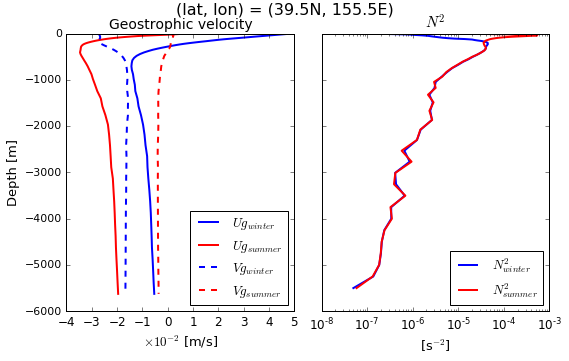

In [35]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(121)
ax1.plot(
            Ug_winKuro[:, 6, 5]*1e2, - zU, 'b', linewidth=2.0, label=r'$Ug_{winter}$')
ax1.plot(
            Ug_sumKuro[:, 6, 5]*1e2, - zU, 'r', linewidth=2.0, label='$Ug_{summer}$')
ax1.plot(
            Vg_winKuro[:, 6, 5]*1e2, - zU, 'b--', linewidth=2.0, label='$Vg_{winter}$')
ax1.plot(
            Vg_sumKuro[:, 6, 5]*1e2, - zU, 'r--', linewidth=2.0, label='$Vg_{summer}$')
ax1.set_title(r'Geostrophic velocity', fontsize=14)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel(r'$\times 10^{-2}$ [m/s]', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
plt.legend(loc='lower right', fontsize=13)

ax2 = fig.add_subplot(122)
ax2.semilogx(
            N2_winKuro[:, 6, 5], zN2_winKuro[:, 6, 5], 'b', linewidth=2.0, label=r'$N^2_{winter}$')
ax2.semilogx(
            N2_sumKuro[:, 6, 5], zN2_sumKuro[:, 6, 5], 'r', linewidth=2.0, label=r'$N^2_{summer}$')
ax2.set_title(r'$N^2$', fontsize=15)
ax2.set_xlabel('[s$^{-2}$]', fontsize=13)
plt.xticks(fontsize=12)
plt.setp( ax2.get_yticklabels(), visible=False)
plt.legend(loc='lower right', fontsize=13)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
# plt.suptitle(r'(lat, lon) = (39.5N, 155.5E)', fontsize=16, y=1.02)
fig.get_axes()[0].annotate(r'(lat, lon) = (39.5N, 155.5E)', (0.5, 0.96), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=16
                            )
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()
plt.savefig('UgVg_N2_Kuroshio.png', box_axis='tight')

In [27]:
(k_winK, Ug_winK, Vg_winK, N2_winK, Rd_winK, Rd_MLwinK, 
     mu_winK, mu_MLwinK, zN2_winK, Ri_invsqrt_winK, Ri_invsqrt_MLwinK, 
     Ri_MLwinK, sigma2D_winK, amp2D_winK, 
     Eady_winK, Eady_MLwinK, Stone_winK) = set_of_results(Ug_winmeta,
                                                                                Vg_winmeta, zU, lats_Kuro, lons_Kuro, N2_winmeta, zN2_winmeta, 
                                                                                               H_winmeta, MLD_winmeta, Ri_winmeta, 5, 5)

Latitude: 39.466  Longitude: 155.45


In [28]:
print Rd_MLwinK

1553.5882843


In [29]:
(k_sumK, Ug_sumK, Vg_sumK, N2_sumK, Rd_sumK, Rd_MLsumK, 
     mu_sumK, mu_MLsumK, zN2_sumK, Ri_invsqrt_sumK, Ri_invsqrt_MLsumK, 
     Ri_MLsumK, sigma2D_sumK, amp2D_sumK, 
     Eady_sumK, Eady_MLsumK, Stone_sumK) = set_of_results(Ug_summeta,
                                                                                Vg_summeta, zU, lats_Kuro, lons_Kuro, N2_summeta, zN2_summeta, 
                                                                                               H_summeta, MLD_summeta, Ri_summeta, 5, 5)

Latitude: 39.466  Longitude: 155.45


In [30]:
np.savez('POP_Kuroshio_growthrates',
         Uwin=Ug_winK, Usum=Ug_sumK, Vwin=Vg_winK, Vsum=Vg_sumK,
         N2win=N2_winK, N2sum=N2_sumK,
         zN2win=zN2_winK, zN2sum=zN2_sumK,
         k_win=k_winK, k_sum=k_sumK,
         sigma_win=sigma2D_winK[0], sigma_sum=sigma2D_sumK[0],
         amp_win=amp2D_winK[:, 0], amp_sum=amp2D_sumK[:, 0],
         Eady_win=Eady_winK, Eady_sum=Eady_sumK,
         Eady_MLwin=Eady_MLwinK, Eady_MLsum=Eady_MLsumK,
         Stone_win=Stone_winK, Stone_sum=Stone_sumK,
         Rd_win=Rd_winK, Rd_sum=Rd_sumK,
         Rd_MLwin=Rd_MLwinK, Rd_MLsum=Rd_MLsumK)

In [31]:
Kuronpz = np.load(os.path.join(basedir, 'POP_Kuroshio_growthrates.npz'))
print Kuronpz.files
k_winK = Kuronpz['k_win']
k_sumK = Kuronpz['k_sum']
sigma2D_winK = Kuronpz['sigma_win']
sigma2D_sumK = Kuronpz['sigma_sum']
Eady_winK = Kuronpz['Eady_win']
Eady_sumK = Kuronpz['Eady_sum']
Eady_MLwinK = Kuronpz['Eady_MLwin']
Eady_MLsumK = Kuronpz['Eady_MLsum']
Rd_winK = Kuronpz['Rd_win']
Rd_sumK = Kuronpz['Rd_sum']
Rd_MLwinK = Kuronpz['Rd_MLwin']
Rd_MLsumK = Kuronpz['Rd_MLsum']

['Vwin', 'Stone_win', 'zN2win', 'N2win', 'Usum', 'sigma_win', 'k_win', 'N2sum', 'Eady_win', 'amp_sum', 'Eady_MLsum', 'Uwin', 'Rd_MLwin', 'Rd_MLsum', 'k_sum', 'zN2sum', 'amp_win', 'Eady_MLwin', 'sigma_sum', 'Rd_win', 'Vsum', 'Eady_sum', 'Rd_sum', 'Stone_sum']


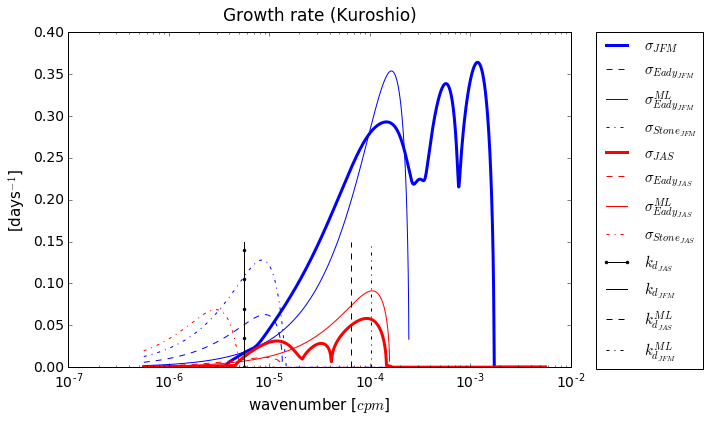

In [36]:
fig = plt.figure(figsize=(9, 6))

ax1 = plt.gca()
ax1.semilogx(
            k_winK*.5*np.pi**-1, sigma2D_winK*24*3600, 
    'b', linewidth=3.0, label=r'$\sigma_{JFM}$')
ax1.semilogx(
            k_winK*.5*np.pi**-1, Eady_winK*24*3600, 
    'b--', label=r'$\sigma_{Eady_{JFM}}$')
ax1.semilogx(
            k_winK*.5*np.pi**-1, Eady_MLwinK*24*3600, 
    'b', label=r'$\sigma^{ML}_{Eady_{JFM}}$')
ax1.semilogx(
            k_winK*.5*np.pi**-1, Stone_winK*24*3600, 
    'b-.', label=r'$\sigma_{Stone_{JFM}}$')
ax1.semilogx(
            k_sumK*.5*np.pi**-1, sigma2D_sumK*24*3600, 
    'r', linewidth=3.0, label=r'$\sigma_{JAS}$')
ax1.semilogx(
            k_sumK*.5*np.pi**-1, Eady_sumK*24*3600, 
    'r--', label=r'$\sigma_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumK*.5*np.pi**-1, Eady_MLsumK*24*3600, 
    'r', label=r'$\sigma^{ML}_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumK*.5*np.pi**-1, Stone_sumK*24*3600, 
    'r-.', label=r'$\sigma_{Stone_{JAS}}$')
ax1.plot(Rd_sumK**-1*np.ones(5)*.5*np.pi**-1, np.linspace(0.,.14,5), 
         'k.-', label=r'$k_{d_{JAS}}$')
ax1.plot(Rd_winK**-1*np.ones(5)*.5*np.pi**-1, np.linspace(0.,.15,5), 
         'k', label=r'$k_{d_{JFM}}$')
ax1.plot(Rd_MLsumK**-1*np.ones(5)*.5*np.pi**-1, np.linspace(0.,.15,5), 
         'k--', label=r'$k^{ML}_{d_{JAS}}$')
ax1.plot(Rd_MLwinK**-1*np.ones(5)*.5*np.pi**-1, np.linspace(0.,.15,5), 
         'k-.', label=r'$k^{ML}_{d_{JFM}}$')
ax1.set_title(r'Growth rate (Kuroshio)', fontsize=17, y = 1.02)
ax1.set_ylabel(r'[days$^{-1}$]', fontsize=15)
ax1.set_xlabel(r'wavenumber [$cpm$]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)

plt.savefig('POP_growthrate_Kuroshio_season.png', bbox_inches='tight')

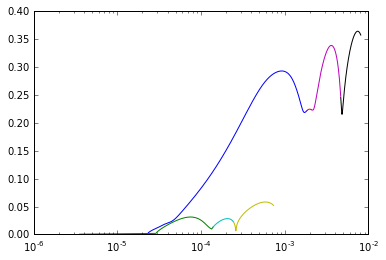

In [248]:
fig = plt.figure()

ax = plt.gca()
ax.semilogx(k_winK[:3400], sigma2D_winK[0, :3400]*24*3600)
ax.semilogx(k_sumK[:2000], sigma2D_sumK[0, :2000]*24*3600)
ax.semilogx(k_winK[3400:3460], sigma2D_winK[0, 3400:3460]*24*3600)
ax.semilogx(k_sumK[2000:2300], sigma2D_sumK[0, 2000:2300]*24*3600)
ax.semilogx(k_winK[3460:3900], sigma2D_winK[0, 3460:3900]*24*3600)
ax.semilogx(k_sumK[2300:2900], sigma2D_sumK[0, 2300:2900]*24*3600)
ax.semilogx(k_winK[3900:4200], sigma2D_winK[0, 3900:4200]*24*3600)

In [249]:
amp_winK0 = amp2D_winK[:, 0, np.nanargmax(sigma2D_sumK[0, :2000])]
amp_winK1 = amp2D_winK[:, 0, np.nanargmax(sigma2D_winK[0, :3400])]
amp_sumK1 = amp2D_sumK[:, 0, np.nanargmax(sigma2D_sumK[0, :2000])]
amp_winK2 = amp2D_winK[:, 0, np.nanargmax(sigma2D_winK[0, 3400:3460])]
amp_sumK2 = amp2D_sumK[:, 0, np.nanargmax(sigma2D_sumK[0, 2000:2300])]
amp_winK3 = amp2D_winK[:, 0, np.nanargmax(sigma2D_winK[0, 3460:3900])]
amp_sumK3 = amp2D_sumK[:, 0, np.nanargmax(sigma2D_sumK[0, 2300:2900])]
amp_winK4 = amp2D_winK[:, 0, np.nanargmax(sigma2D_winK[0, 3900:4200])]

In [57]:
print zU.shape, amp_winK0.shape

(62,) (61,)


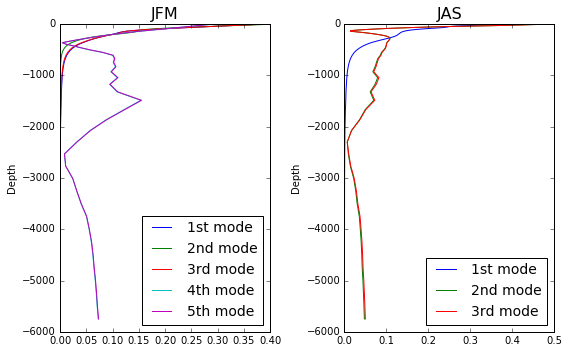

In [212]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(121)
ax1.plot(
            amp_winK0, zN2_winK, label='1st mode')
ax1.plot(
            amp_winK1, zN2_winK, label='2nd mode')
ax1.plot(
            amp_winK2, zN2_winK, label='3rd mode')
ax1.plot(
            amp_winK3, zN2_winK, label='4th mode')
ax1.plot(
            amp_winK4, zN2_winK, label='5th mode')
ax1.set_title(r'JFM', fontsize=16)
ax1.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(
            amp_sumK1, zN2_sumK, label='1st mode')
ax2.plot(
            amp_sumK2, zN2_sumK, label='2nd mode')
ax2.plot(
            amp_sumK3, zN2_sumK, label='3rd mode')
ax2.set_title(r'JAS', fontsize=16)
ax2.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
# plt.suptitle(r'(lat, lon) = (39.5N, 155.5E)', fontsize=14, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()
plt.savefig('POP_verticalAmp_Kuroshio_season.png')

## North of Kuroshio (44N, 172E)

In [37]:
lats_NK = (44., 45.)
lons_NK = (1.71950000e+02, 1.72950000e+02)

In [38]:
(k_winNK, Ug_winNK, Vg_winNK, N2_winNK, Rd_winNK, Rd_MLwinNK, 
     mu_winNK, mu_MLwinNK, zN2_winNK, Ri_invsqrt_winNK, Ri_invsqrt_MLwinNK, 
     Ri_MLwinNK, sigma2D_winNK, amp2D_winNK, 
     Eady_winNK, Eady_MLwinNK, Stone_winNK) = set_of_results(Ug_winmeta,
                                                                                Vg_winmeta, zU, lats_NK, lons_NK, N2_winmeta, zN2_winmeta, 
                                                                                               H_winmeta, MLD_winmeta, Ri_winmeta, 5, 5)

Latitude: 44.462  Longitude: 172.45


In [39]:
(k_sumNK, Ug_sumNK, Vg_sumNK, N2_sumNK, Rd_sumNK, Rd_MLsumNK, 
     mu_sumNK, mu_MLsumNK, zN2_sumNK, Ri_invsqrt_sumNK, Ri_invsqrt_MLsumNK, 
     Ri_MLsumNK, sigma2D_sumNK, amp2D_sumNK, 
     Eady_sumNK, Eady_MLsumNK, Stone_sumNK) = set_of_results(Ug_summeta,
                                                                                Vg_summeta, zU, lats_NK, lons_NK, N2_summeta, zN2_summeta, 
                                                                                               H_summeta, MLD_summeta, Ri_summeta, 5, 5)

Latitude: 44.462  Longitude: 172.45


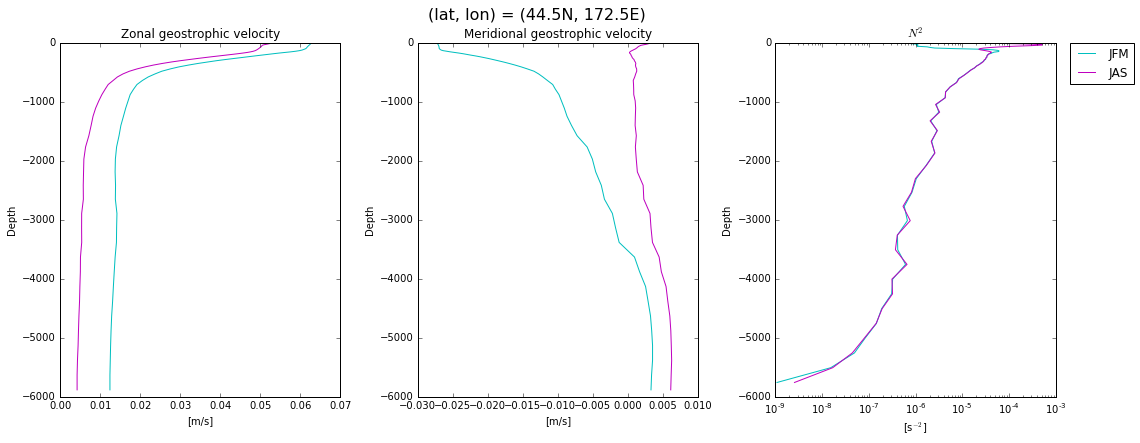

In [253]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.plot(
            Ug_winNK, - zU, 'c', label='winter')
ax1.plot(
            Ug_sumNK, - zU, 'm', label='summer')
ax1.set_title(r'Zonal geostrophic velocity')
ax1.set_ylabel('Depth')
ax1.set_xlabel('[m/s]')

ax2 = fig.add_subplot(132)
ax2.plot(
            Vg_winNK, - zU, 'c', label='winter')
ax2.plot(
            Vg_sumNK, - zU, 'm', label='summer')
ax2.set_title(r'Meridional geostrophic velocity')
ax2.set_ylabel('Depth')
ax2.set_xlabel('[m/s]')

ax3 = fig.add_subplot(133)
ax3.semilogx(
            N2_winNK, zN2_winNK, 'c', label='JFM')
ax3.semilogx(
            N2_sumNK, zN2_sumNK, 'm', label='JAS')
ax3.set_title(r'$N^2$')
ax3.set_ylabel('Depth')
ax3.set_xlabel('[s$^{-2}$]')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.suptitle(r'(lat, lon) = (44.5N, 172.5E)', fontsize=16, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()

In [40]:
np.savez('POP_NorthofKuroshio_growthrates',
         Uwin=Ug_winNK, Usum=Ug_sumNK, Vwin=Vg_winNK, Vsum=Vg_sumNK,
         N2win=N2_winNK, N2sum=N2_sumNK,
         zN2win=zN2_winNK, zN2sum=zN2_sumNK,
         k_win=k_winNK, k_sum=k_sumNK,
         sigma_win=sigma2D_winNK[0], sigma_sum=sigma2D_sumNK[0],
         amp_win=amp2D_winNK[:, 0], amp_sum=amp2D_sumNK[:, 0],
         Eady_win=Eady_winNK, Eady_sum=Eady_sumNK,
         Eady_MLwin=Eady_MLwinNK, Eady_MLsum=Eady_MLsumNK,
         Stone_win=Stone_winNK, Stone_sum=Stone_sumNK,
         Rd_win=Rd_winNK, Rd_sum=Rd_sumNK,
         Rd_MLwin=Rd_MLwinNK, Rd_MLsum=Rd_MLsumNK)

In [41]:
NKnpz = np.load(os.path.join(basedir, 'POP_NorthofKuroshio_growthrates.npz'))
print NKnpz.files
k_winNK = NKnpz['k_win']
k_sumNK = NKnpz['k_sum']
sigma2D_winNK = NKnpz['sigma_win']
sigma2D_sumNK = NKnpz['sigma_sum']
Eady_winNK = NKnpz['Eady_win']
Eady_sumNK = NKnpz['Eady_sum']
Eady_MLwinNK = NKnpz['Eady_MLwin']
Eady_MLsumNK = NKnpz['Eady_MLsum']
Rd_winNK = NKnpz['Rd_win']
Rd_sumNK = NKnpz['Rd_sum']
Rd_MLwinNK = NKnpz['Rd_MLwin']
Rd_MLsumNK = NKnpz['Rd_MLsum']

['Vwin', 'Stone_win', 'zN2win', 'N2win', 'Usum', 'sigma_win', 'k_win', 'N2sum', 'Eady_win', 'amp_sum', 'Eady_MLsum', 'Uwin', 'Rd_MLwin', 'Rd_MLsum', 'k_sum', 'zN2sum', 'amp_win', 'Eady_MLwin', 'sigma_sum', 'Rd_win', 'Vsum', 'Eady_sum', 'Rd_sum', 'Stone_sum']


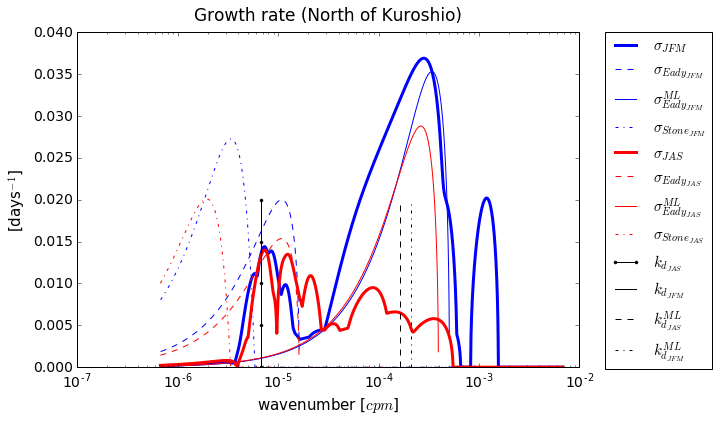

In [47]:
fig = plt.figure(figsize=(9, 6))

ax1 = plt.gca()
ax1.semilogx(
            k_winNK*.5*np.pi**-1, sigma2D_winNK*24*3600, 
    'b', linewidth=3.0, label=r'$\sigma_{JFM}$')
ax1.semilogx(
            k_winNK*.5*np.pi**-1, Eady_winNK*24*3600, 
    'b--', label=r'$\sigma_{Eady_{JFM}}$')
ax1.semilogx(
            k_winNK*.5*np.pi**-1, Eady_MLwinNK*24*3600, 
    'b', label=r'$\sigma^{ML}_{Eady_{JFM}}$')
ax1.semilogx(
            k_winNK*.5*np.pi**-1, Stone_winNK*24*3600, 
    'b-.', label=r'$\sigma_{Stone_{JFM}}$')
ax1.semilogx(
            k_sumNK*.5*np.pi**-1, sigma2D_sumNK*24*3600, 
    'r', linewidth=3.0, label=r'$\sigma_{JAS}$')
ax1.semilogx(
            k_sumNK*.5*np.pi**-1, Eady_sumNK*24*3600, 
    'r--', label=r'$\sigma_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumNK*.5*np.pi**-1, Eady_MLsumNK*24*3600, 
    'r', label=r'$\sigma^{ML}_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumNK*.5*np.pi**-1, Stone_sumNK*24*3600, 
    'r-.', label=r'$\sigma_{Stone_{JAS}}$')
ax1.plot(Rd_sumNK**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.02,5), 
         'k.-', label=r'$k_{d_{JAS}}$')
ax1.plot(Rd_winNK**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.02,5), 
         'k', label=r'$k_{d_{JFM}}$')
ax1.plot(Rd_MLsumNK**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.02,5), 
         'k--', label=r'$k^{ML}_{d_{JAS}}$')
ax1.plot(Rd_MLwinNK**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.02,5), 
         'k-.', label=r'$k^{ML}_{d_{JFM}}$')
ax1.set_title(r'Growth rate (North of Kuroshio)', fontsize=17, y=1.02)
ax1.set_ylabel(r'[days$^{-1}$]', fontsize=15)
ax1.set_xlabel(r'wavenumber [$cpm$]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.savefig('POP_growthrate_NorthKuro_season.png', bbox_inches='tight')

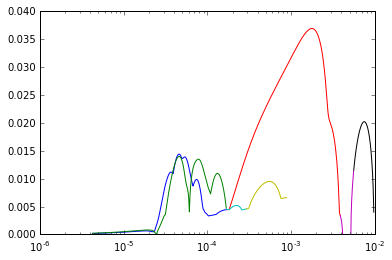

In [77]:
fig = plt.figure()

ax = plt.gca()
ax.semilogx(k_winNK[:2000], sigma2D_winNK[0, :2000]*24*3600)
ax.semilogx(k_sumNK[:2000], sigma2D_sumNK[0, :2000]*24*3600)
ax.semilogx(k_winNK[2000:3700], sigma2D_winNK[0, 2000:3700]*24*3600)
ax.semilogx(k_sumNK[2000:2300], sigma2D_sumNK[0, 2000:2300]*24*3600)
ax.semilogx(k_winNK[3700:3900], sigma2D_winNK[0, 3700:3900]*24*3600)
ax.semilogx(k_sumNK[2300:2900], sigma2D_sumNK[0, 2300:2900]*24*3600)
ax.semilogx(k_winNK[3900:4200], sigma2D_winNK[0, 3900:4200]*24*3600)

In [85]:
amp_winNK1 = amp2D_winNK[:, 0, np.nanargmax(sigma2D_winNK[0, :2000])]
amp_sumNK1 = amp2D_sumNK[:, 0, np.nanargmax(sigma2D_sumNK[0, :2000])]
amp_winNK2 = amp2D_winNK[:, 0, np.nanargmax(sigma2D_winNK[0, 2000:3700])]
amp_sumNK2 = amp2D_sumNK[:, 0, np.nanargmax(sigma2D_sumNK[0, 2000:2300])]
amp_winNK3 = amp2D_winNK[:, 0, np.nanargmax(sigma2D_winNK[0, 3900:4200])]
amp_sumNK3 = amp2D_sumNK[:, 0, np.nanargmax(sigma2D_sumNK[0, 2300:2900])]

In [83]:
print amp_winNK1.shape, zN2_winNK.shape

(62,) (61,)


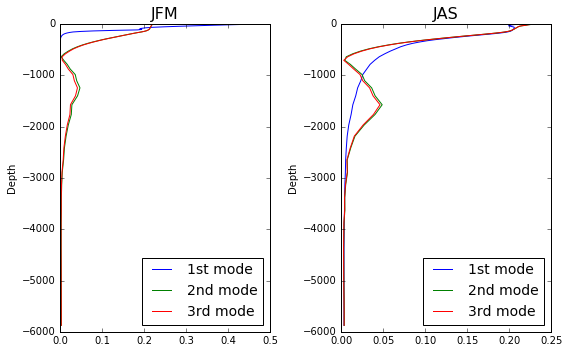

In [214]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(121)
ax1.plot(
            amp_winNK1, -zU, label='1st mode')
ax1.plot(
            amp_winNK2, -zU, label='2nd mode')
ax1.plot(
            amp_winNK3, -zU, label='3rd mode')
ax1.set_title(r'JFM', fontsize=16)
ax1.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(
            amp_sumNK1, -zU, label='1st mode')
ax2.plot(
            amp_sumNK2, -zU, label='2nd mode')
ax2.plot(
            amp_sumNK3, -zU, label='3rd mode')
ax2.set_title(r'JAS', fontsize=16)
ax2.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
# plt.suptitle(r'(lat, lon) = (39.5N, 155.5E)', fontsize=14, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()
plt.savefig('POP_verticalAmp_NorthKuro_season.png')

## East Pacific (17N, 240E)

In [43]:
lats_EP = (17., 18.)
lons_EP = (2.39950000e+02, 2.40950000e+02)

In [44]:
(k_winEP, Ug_winEP, Vg_winEP, N2_winEP, Rd_winEP, Rd_MLwinEP, 
     mu_winEP, mu_MLwinEP, zN2_winEP, Ri_invsqrt_winEP, Ri_invsqrt_MLwinEP, 
     Ri_MLwinEP, sigma2D_winEP, amp2D_winEP, 
     Eady_winEP, Eady_MLwinEP, Stone_winEP) = set_of_results(Ug_winmeta,
                                                                                Vg_winmeta, zU, lats_EP, lons_EP, N2_winmeta, zN2_winmeta, 
                                                                                               H_winmeta, MLD_winmeta, Ri_winmeta, 5, 5)

Latitude: 17.57  Longitude: 240.45


In [45]:
(k_sumEP, Ug_sumEP, Vg_sumEP, N2_sumEP, Rd_sumEP, Rd_MLsumEP, 
     mu_sumEP, mu_MLsumEP, zN2_sumEP, Ri_invsqrt_sumEP, Ri_invsqrt_MLsumEP, 
     Ri_MLsumEP, sigma2D_sumEP, amp2D_sumEP, 
     Eady_sumEP, Eady_MLsumEP, Stone_sumEP) = set_of_results(Ug_summeta,
                                                                                Vg_summeta, zU, lats_EP, lons_EP, N2_summeta, zN2_summeta, 
                                                                                               H_summeta, MLD_summeta, Ri_summeta, 5, 5)

Latitude: 17.57  Longitude: 240.45


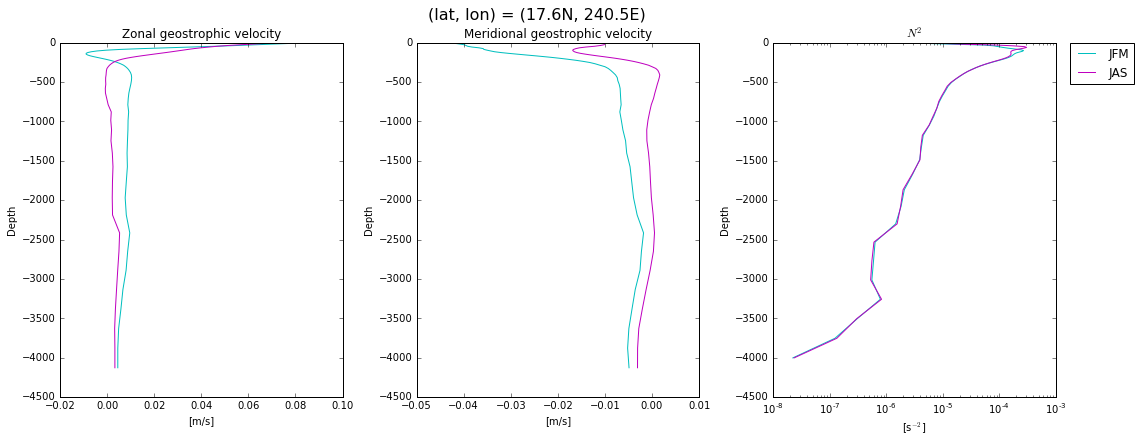

In [191]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.plot(
            Ug_winEP, - zU, 'c', label='JFM')
ax1.plot(
            Ug_sumEP, - zU, 'm', label='JAS')
ax1.set_title(r'Zonal geostrophic velocity')
ax1.set_ylabel('Depth')
ax1.set_xlabel('[m/s]')

ax2 = fig.add_subplot(132)
ax2.plot(
            Vg_winEP, - zU, 'c', label='JFM')
ax2.plot(
            Vg_sumEP, - zU, 'm', label='JAS')
ax2.set_title(r'Meridional geostrophic velocity')
ax2.set_ylabel('Depth')
ax2.set_xlabel('[m/s]')

ax3 = fig.add_subplot(133)
ax3.semilogx(
            N2_winEP, zN2_winEP, 'c', label='JFM')
ax3.semilogx(
            N2_sumEP, zN2_sumEP, 'm', label='JAS')
ax3.set_title(r'$N^2$')
ax3.set_ylabel('Depth')
ax3.set_xlabel('[s$^{-2}$]')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.suptitle(r'(lat, lon) = (17.6N, 240.5E)', fontsize=16, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()

In [46]:
np.savez('POP_EastPacific_growthrates',
         Uwin=Ug_winEP, Usum=Ug_sumEP, Vwin=Vg_winEP, Vsum=Vg_sumEP,
         N2win=N2_winEP, N2sum=N2_sumEP,
         zN2win=zN2_winEP, zN2sum=zN2_sumEP,
         k_win=k_winEP, k_sum=k_sumEP,
         sigma_win=sigma2D_winEP[0], sigma_sum=sigma2D_sumEP[0],
         amp_win=amp2D_winEP[:, 0], amp_sum=amp2D_sumEP[:, 0],
         Eady_win=Eady_winEP, Eady_sum=Eady_sumEP,
         Eady_MLwin=Eady_MLwinEP, Eady_MLsum=Eady_MLsumEP,
         Stone_win=Stone_winEP, Stone_sum=Stone_sumEP,
         Rd_win=Rd_winEP, Rd_sum=Rd_sumEP,
         Rd_MLwin=Rd_MLwinEP, Rd_MLsum=Rd_MLsumEP)

In [48]:
EPnpz = np.load(os.path.join(basedir, 'POP_EastPacific_growthrates.npz'))
print EPnpz.files
k_winEP = EPnpz['k_win']
k_sumEP = EPnpz['k_sum']
sigma2D_winEP = EPnpz['sigma_win']
sigma2D_sumEP = EPnpz['sigma_sum']
Eady_winEP = EPnpz['Eady_win']
Eady_sumEP = EPnpz['Eady_sum']
Eady_MLwinEP = EPnpz['Eady_MLwin']
Eady_MLsumEP = EPnpz['Eady_MLsum']
Rd_winEP = EPnpz['Rd_win']
Rd_sumEP = EPnpz['Rd_sum']
Rd_MLwinEP = EPnpz['Rd_MLwin']
Rd_MLsumEP = EPnpz['Rd_MLsum']

['Vwin', 'Stone_win', 'zN2win', 'N2win', 'Usum', 'sigma_win', 'k_win', 'N2sum', 'Eady_win', 'amp_sum', 'Eady_MLsum', 'Uwin', 'Rd_MLwin', 'Rd_MLsum', 'k_sum', 'zN2sum', 'amp_win', 'Eady_MLwin', 'sigma_sum', 'Rd_win', 'Vsum', 'Eady_sum', 'Rd_sum', 'Stone_sum']


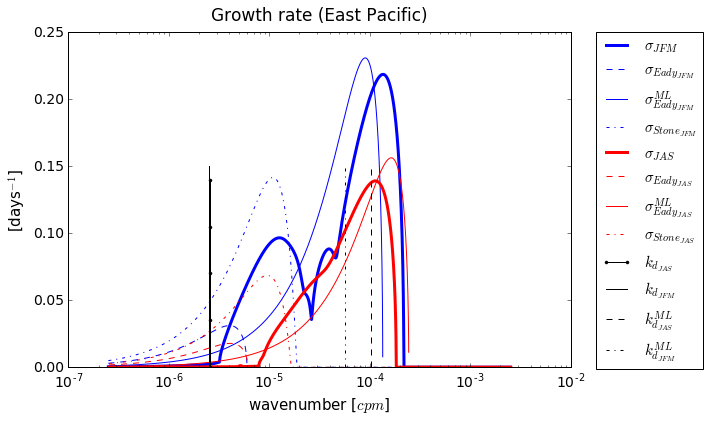

In [50]:
fig = plt.figure(figsize=(9, 6))

ax1 = plt.gca()
ax1.semilogx(
            k_winEP*.5*np.pi**-1, sigma2D_winEP*24*3600, 
    'b', linewidth=3.0, label=r'$\sigma_{JFM}$')
ax1.semilogx(
            k_winEP*.5*np.pi**-1, Eady_winEP*24*3600, 
    'b--', label=r'$\sigma_{Eady_{JFM}}$')
ax1.semilogx(
            k_winEP*.5*np.pi**-1, Eady_MLwinEP*24*3600, 
    'b', label=r'$\sigma^{ML}_{Eady_{JFM}}$')
ax1.semilogx(
            k_winEP*.5*np.pi**-1, Stone_winEP*24*3600, 
    'b-.', label=r'$\sigma_{Stone_{JFM}}$')
ax1.semilogx(
            k_sumEP*.5*np.pi**-1, sigma2D_sumEP*24*3600, 
    'r', linewidth=3.0, label=r'$\sigma_{JAS}$')
ax1.semilogx(
            k_sumEP*.5*np.pi**-1, Eady_sumEP*24*3600, 
    'r--', label=r'$\sigma_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumEP*.5*np.pi**-1, Eady_MLsumEP*24*3600, 
    'r', label=r'$\sigma^{ML}_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumEP*.5*np.pi**-1, Stone_sumEP*24*3600, 
    'r-.', label=r'$\sigma_{Stone_{JAS}}$')
ax1.plot(Rd_sumEP**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.14,5), 
         'k.-', label=r'$k_{d_{JAS}}$')
ax1.plot(Rd_winEP**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.15,5), 
         'k', label=r'$k_{d_{JFM}}$')
ax1.plot(Rd_MLsumEP**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.15,5), 
         'k--', label=r'$k^{ML}_{d_{JAS}}$')
ax1.plot(Rd_MLwinEP**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.15,5), 
         'k-.', label=r'$k^{ML}_{d_{JFM}}$')
ax1.set_title(r'Growth rate (East Pacific)', fontsize=17, y = 1.02)
ax1.set_ylabel(r'[days$^{-1}$]', fontsize=15)
ax1.set_xlabel(r'wavenumber [$cpm$]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.savefig('POP_growthrate_EastPacific_season.png', bbox_inches='tight')

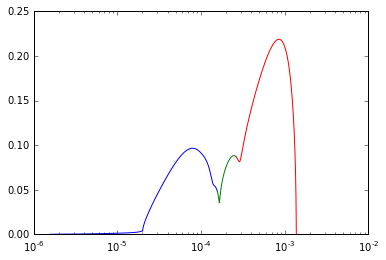

In [103]:
fig = plt.figure()

ax = plt.gca()
ax.semilogx(k_winEP[:2500], sigma2D_winEP[0, :2500]*24*3600)
# ax.semilogx(k_sumEP[:3000], sigma2D_sumEP[0, :3000]*24*3600)
ax.semilogx(k_winEP[2500:2780], sigma2D_winEP[0, 2500:2780]*24*3600)
# ax.semilogx(k_sumEP[2000:2300], sigma2D_sumEP[0, 2000:2300]*24*3600)
ax.semilogx(k_winEP[2780:3900], sigma2D_winEP[0, 2780:3900]*24*3600)
# ax.semilogx(k_sumEP[2300:2900], sigma2D_sumEP[0, 2300:2900]*24*3600)
ax.semilogx(k_winEP[3900:4200], sigma2D_winEP[0, 3900:4200]*24*3600)

In [105]:
amp_winEP1 = amp2D_winEP[:, 0, np.nanargmax(sigma2D_winEP[0, :2500])]
amp_sumEP1 = amp2D_sumEP[:, 0, np.nanargmax(sigma2D_sumEP[0])]
amp_winEP2 = amp2D_winEP[:, 0, np.nanargmax(sigma2D_winEP[0, 2500:2780])]
# amp_sumNK2 = amp2D_sumNK[:, 0, np.nanargmax(sigma2D_sumNK[0, 2000:2300])]
amp_winEP3 = amp2D_winEP[:, 0, np.nanargmax(sigma2D_winEP[0, 2780:3900])]
# amp_sumNK3 = amp2D_sumNK[:, 0, np.nanargmax(sigma2D_sumNK[0, 2300:2900])]

In [108]:
print amp_winEP1.shape

(55,)


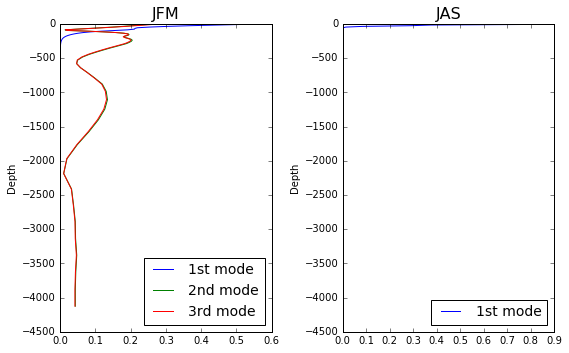

In [216]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(121)
ax1.plot(
            amp_winEP1, -zU[:len(amp_winEP1)], label='1st mode')
ax1.plot(
            amp_winEP2, -zU[:len(amp_winEP1)], label='2nd mode')
ax1.plot(
            amp_winEP3, -zU[:len(amp_winEP1)], label='3rd mode')
ax1.set_title(r'JFM', fontsize=16)
ax1.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(
            amp_sumEP1, -zU[:len(amp_winEP1)], label='1st mode')
# ax2.plot(
#             amp_sumNK2, -zU, label='2nd mode')
# ax2.plot(
#             amp_sumNK3, -zU, label='3rd mode')
ax2.set_title(r'JAS', fontsize=16)
ax2.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
# plt.suptitle(r'(lat, lon) = (39.5N, 155.5E)', fontsize=14, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()
plt.savefig('POP_verticalAmp_EastPacific_season.png')

# Atlantic

## Gulf Stream (41.5N, 300.5E)

In [51]:
lats_GS = (41., 42.)
lons_GS = (2.99950000e+02, 3.00950000e+02)

In [52]:
(k_winGS, Ug_winGS, Vg_winGS, N2_winGS, Rd_winGS, Rd_MLwinGS, 
     mu_winGS, mu_MLwinGS, zN2_winGS, Ri_invsqrt_winGS, Ri_invsqrt_MLwinGS, 
     Ri_MLwinGS, sigma2D_winGS, amp2D_winGS, 
     Eady_winGS, Eady_MLwinGS, Stone_winGS) = set_of_results(Ug_winmeta,
                                                                                Vg_winmeta, zU, lats_GS, lons_GS, N2_winmeta, zN2_winmeta, 
                                                                                               H_winmeta, MLD_winmeta, Ri_winmeta, 5, 5)

Latitude: 41.452  Longitude: 300.45


In [53]:
(k_sumGS, Ug_sumGS, Vg_sumGS, N2_sumGS, Rd_sumGS, Rd_MLsumGS, 
     mu_sumGS, mu_MLsumGS, zN2_sumGS, Ri_invsqrt_sumGS, Ri_invsqrt_MLsumGS, 
     Ri_MLsumGS, sigma2D_sumGS, amp2D_sumGS, 
     Eady_sumGS, Eady_MLsumGS, Stone_sumGS) = set_of_results(Ug_summeta,
                                                                                Vg_summeta, zU, lats_GS, lons_GS, N2_summeta, zN2_summeta, 
                                                                                               H_summeta, MLD_summeta, Ri_summeta, 5, 5)

Latitude: 41.452  Longitude: 300.45


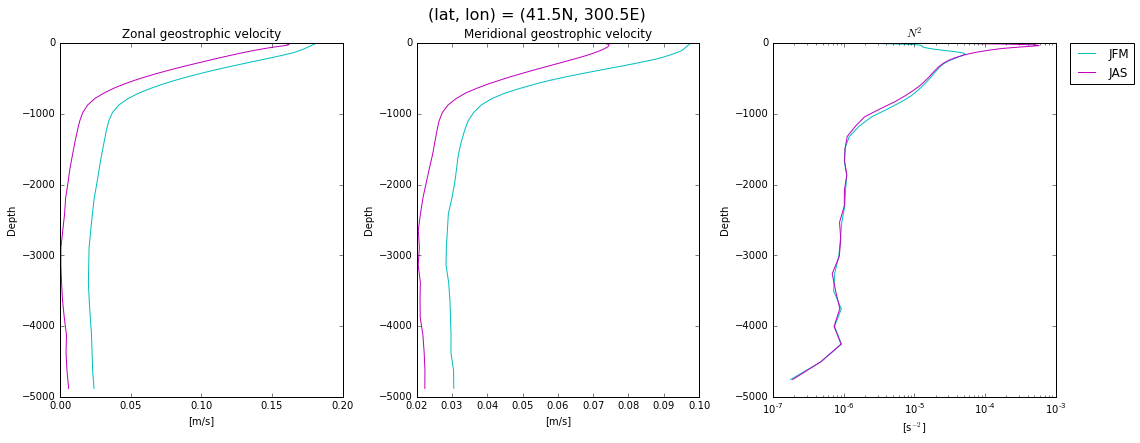

In [188]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.plot(
            Ug_winGS, - zU, 'c', label='JFM')
ax1.plot(
            Ug_sumGS, - zU, 'm', label='JAS')
ax1.set_title(r'Zonal geostrophic velocity')
ax1.set_ylabel('Depth')
ax1.set_xlabel('[m/s]')

ax2 = fig.add_subplot(132)
ax2.plot(
            Vg_winGS, - zU, 'c', label='JFM')
ax2.plot(
            Vg_sumGS, - zU, 'm', label='JAS')
ax2.set_title(r'Meridional geostrophic velocity')
ax2.set_ylabel('Depth')
ax2.set_xlabel('[m/s]')

ax3 = fig.add_subplot(133)
ax3.semilogx(
            N2_winGS, zN2_winGS, 'c', label='JFM')
ax3.semilogx(
            N2_sumGS, zN2_sumGS, 'm', label='JAS')
ax3.set_title(r'$N^2$')
ax3.set_ylabel('Depth')
ax3.set_xlabel('[s$^{-2}$]')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.suptitle(r'(lat, lon) = (41.5N, 300.5E)', fontsize=16, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()

In [54]:
np.savez('POP_GulfStream_growthrates',
         Uwin=Ug_winGS, Usum=Ug_sumGS, Vwin=Vg_winGS, Vsum=Vg_sumGS,
         N2win=N2_winGS, N2sum=N2_sumGS,
         zN2win=zN2_winGS, zN2sum=zN2_sumGS,
         k_win=k_winGS, k_sum=k_sumGS,
         sigma_win=sigma2D_winGS[0], sigma_sum=sigma2D_sumGS[0],
         amp_win=amp2D_winGS[:, 0], amp_sum=amp2D_sumGS[:, 0],
         Eady_win=Eady_winGS, Eady_sum=Eady_sumGS,
         Eady_MLwin=Eady_MLwinGS, Eady_MLsum=Eady_MLsumGS,
         Stone_win=Stone_winGS, Stone_sum=Stone_sumGS,
         Rd_win=Rd_winGS, Rd_sum=Rd_sumGS,
         Rd_MLwin=Rd_MLwinGS, Rd_MLsum=Rd_MLsumGS)

In [55]:
GSnpz = np.load(os.path.join(basedir, 'POP_GulfStream_growthrates.npz'))
print GSnpz.files
k_winGS = GSnpz['k_win']
k_sumGS = GSnpz['k_sum']
sigma2D_winGS = GSnpz['sigma_win']
sigma2D_sumGS = GSnpz['sigma_sum']
Eady_winGS = GSnpz['Eady_win']
Eady_sumGS = GSnpz['Eady_sum']
Eady_MLwinGS = GSnpz['Eady_MLwin']
Eady_MLsumGS = GSnpz['Eady_MLsum']
Rd_winGS = GSnpz['Rd_win']
Rd_sumGS = GSnpz['Rd_sum']
Rd_MLwinGS = GSnpz['Rd_MLwin']
Rd_MLsumGS = GSnpz['Rd_MLsum']

['Vwin', 'Stone_win', 'zN2win', 'N2win', 'Usum', 'sigma_win', 'k_win', 'N2sum', 'Eady_win', 'amp_sum', 'Eady_MLsum', 'Uwin', 'Rd_MLwin', 'Rd_MLsum', 'k_sum', 'zN2sum', 'amp_win', 'Eady_MLwin', 'sigma_sum', 'Rd_win', 'Vsum', 'Eady_sum', 'Rd_sum', 'Stone_sum']


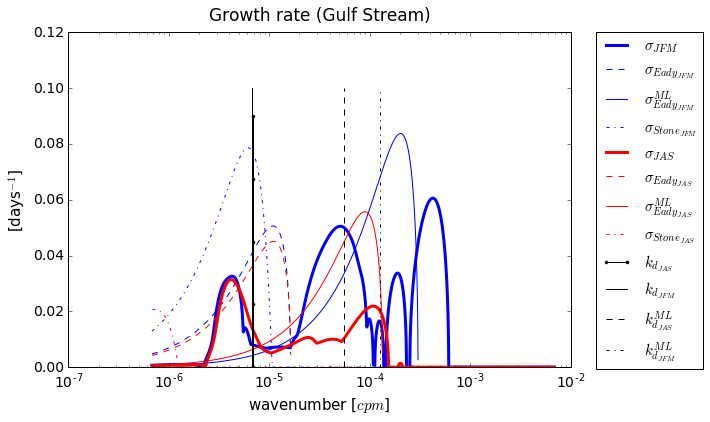

In [56]:
fig = plt.figure(figsize=(9, 6))

ax1 = plt.gca()
ax1.semilogx(
            k_winGS*.5*np.pi**-1, sigma2D_winGS*24*3600, 
    'b', linewidth=3.0, label=r'$\sigma_{JFM}$')
ax1.semilogx(
            k_winGS*.5*np.pi**-1, Eady_winGS*24*3600, 
    'b--', label=r'$\sigma_{Eady_{JFM}}$')
ax1.semilogx(
            k_winGS*.5*np.pi**-1, Eady_MLwinGS*24*3600, 
    'b', label=r'$\sigma^{ML}_{Eady_{JFM}}$')
ax1.semilogx(
            k_winGS*.5*np.pi**-1, Stone_winGS*24*3600, 
    'b-.', label=r'$\sigma_{Stone_{JFM}}$')
ax1.semilogx(
            k_sumGS*.5*np.pi**-1, sigma2D_sumGS*24*3600, 
    'r', linewidth=3.0, label=r'$\sigma_{JAS}$')
ax1.semilogx(
            k_sumGS*.5*np.pi**-1, Eady_sumGS*24*3600, 
    'r--', label=r'$\sigma_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumGS*.5*np.pi**-1, Eady_MLsumGS*24*3600, 
    'r', label=r'$\sigma^{ML}_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumGS*.5*np.pi**-1, Stone_sumGS*24*3600, 
    'r-.', label=r'$\sigma_{Stone_{JAS}}$')
ax1.plot(Rd_sumGS**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.09,5), 
         'k.-', label=r'$k_{d_{JAS}}$')
ax1.plot(Rd_winGS**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.1,5), 
         'k', label=r'$k_{d_{JFM}}$')
ax1.plot(Rd_MLsumGS**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.1,5), 
         'k--', label=r'$k^{ML}_{d_{JAS}}$')
ax1.plot(Rd_MLwinGS**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.1,5), 
         'k-.', label=r'$k^{ML}_{d_{JFM}}$')
ax1.set_title(r'Growth rate (Gulf Stream)', fontsize=17, y=1.02)
ax1.set_ylabel(r'[days$^{-1}$]', fontsize=15)
ax1.set_xlabel(r'wavenumber [$cpm$]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.savefig('POP_growthrate_GulfStream_season.png', bbox_inches='tight')

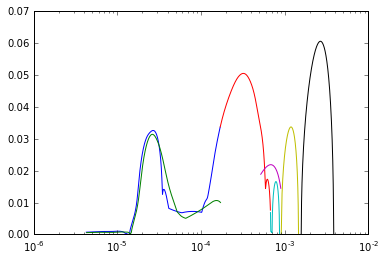

In [125]:
fig = plt.figure()

ax = plt.gca()
ax.semilogx(k_winGS[:2000], sigma2D_winGS[0, :2000]*24*3600)
ax.semilogx(k_sumGS[:2000], sigma2D_sumGS[0, :2000]*24*3600)

ax.semilogx(k_winGS[2000:2750], sigma2D_winGS[0, 2000:2750]*24*3600)
# ax.semilogx(k_sumEP[2000:2300], sigma2D_sumEP[0, 2000:2300]*24*3600)

ax.semilogx(k_winGS[2750:2900], sigma2D_winGS[0, 2750:2900]*24*3600)
ax.semilogx(k_sumGS[2600:2900], sigma2D_sumGS[0, 2600:2900]*24*3600)

ax.semilogx(k_winGS[2900:3200], sigma2D_winGS[0, 2900:3200]*24*3600)

ax.semilogx(k_winGS[3200:4000], sigma2D_winGS[0, 3200:4000]*24*3600)

In [126]:
amp_winGS1 = amp2D_winGS[:, 0, np.nanargmax(sigma2D_winGS[0, :2000])]
amp_sumGS1 = amp2D_sumGS[:, 0, np.nanargmax(sigma2D_sumGS[0, 2000])]
amp_winGS2 = amp2D_winGS[:, 0, np.nanargmax(sigma2D_winGS[0, 2000:2750])]
amp_sumGS2 = amp2D_sumGS[:, 0, np.nanargmax(sigma2D_sumGS[0, 2600:2900])]
amp_winGS3 = amp2D_winGS[:, 0, np.nanargmax(sigma2D_winGS[0, 2750:2900])]
amp_winGS4 = amp2D_winGS[:, 0, np.nanargmax(sigma2D_winGS[0, 2900:3200])]
amp_winGS5 = amp2D_winGS[:, 0, np.nanargmax(sigma2D_winGS[0, 3200:4000])]

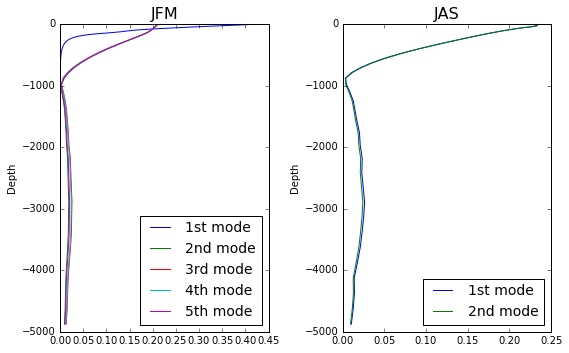

In [218]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(121)
ax1.plot(
            amp_winGS1, -zU[:len(amp_winGS1)], label='1st mode')
ax1.plot(
            amp_winGS2, -zU[:len(amp_winGS1)], label='2nd mode')
ax1.plot(
            amp_winGS3, -zU[:len(amp_winGS1)], label='3rd mode')
ax1.plot(
            amp_winGS4, -zU[:len(amp_winGS1)], label='4th mode')
ax1.plot(
            amp_winGS5, -zU[:len(amp_winGS1)], label='5th mode')
ax1.set_title(r'JFM', fontsize=16)
ax1.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(
            amp_sumGS1, -zU[:len(amp_sumGS1)], label='1st mode')
ax2.plot(
            amp_sumGS2, -zU[:len(amp_sumGS1)], label='2nd mode')
# ax2.plot(
#             amp_sumNK2, -zU, label='2nd mode')
# ax2.plot(
#             amp_sumNK3, -zU, label='3rd mode')
ax2.set_title(r'JAS', fontsize=16)
ax2.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
# plt.suptitle(r'(lat, lon) = (39.5N, 155.5E)', fontsize=14, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()
plt.savefig('POP_verticalAmp_GulfStream_season.png')

## Northeast Atlantic (55.3N, 340.5E)

In [57]:
lats_NEAt = (55., 56.)
lons_NEAt = (3.39950000e+02, 3.40950000e+02)

In [58]:
(k_winNEAt, Ug_winNEAt, Vg_winNEAt, N2_winNEAt, Rd_winNEAt, Rd_MLwinNEAt, 
     mu_winNEAt, mu_MLwinNEAt, zN2_winNEAt, Ri_invsqrt_winNEAt, Ri_invsqrt_MLwinNEAt, 
     Ri_MLwinNEAt, sigma2D_winNEAt, amp2D_winNEAt, 
     Eady_winNEAt, Eady_MLwinNEAt, Stone_winNEAt) = set_of_results(Ug_winmeta,
                                                                                Vg_winmeta, zU, lats_NEAt, lons_NEAt, N2_winmeta, zN2_winmeta, 
                                                                                               H_winmeta, MLD_winmeta, Ri_winmeta, 5, 5)

Latitude: 55.412  Longitude: 340.45


In [59]:
(k_sumNEAt, Ug_sumNEAt, Vg_sumNEAt, N2_sumNEAt, Rd_sumNEAt, Rd_MLsumNEAt, 
     mu_sumNEAt, mu_MLsumNEAt, zN2_sumNEAt, Ri_invsqrt_sumNEAt, Ri_invsqrt_MLsumNEAt, 
     Ri_MLsumNEAt, sigma2D_sumNEAt, amp2D_sumNEAt, 
     Eady_sumNEAt, Eady_MLsumNEAt, Stone_sumNEAt) = set_of_results(Ug_summeta,
                                                                                Vg_summeta, zU, lats_NEAt, lons_NEAt, N2_summeta, zN2_summeta, 
                                                                                               H_summeta, MLD_summeta, Ri_summeta, 5, 5)

Latitude: 55.412  Longitude: 340.45


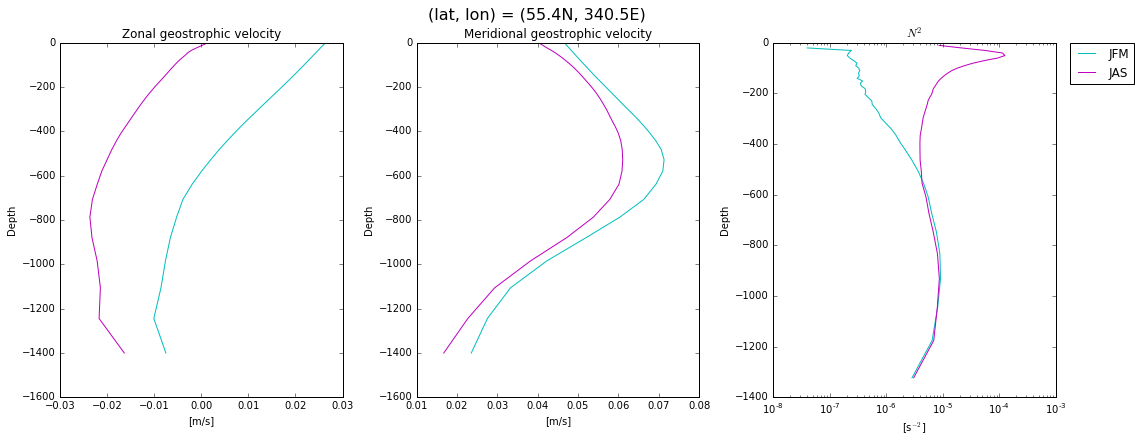

In [200]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.plot(
            Ug_winNEAt, - zU, 'c', label='winter')
ax1.plot(
            Ug_sumNEAt, - zU, 'm', label='summer')
ax1.set_title(r'Zonal geostrophic velocity')
ax1.set_ylabel('Depth')
ax1.set_xlabel('[m/s]')

ax2 = fig.add_subplot(132)
ax2.plot(
            Vg_winNEAt, - zU, 'c', label='winter')
ax2.plot(
            Vg_sumNEAt, - zU, 'm', label='summer')
ax2.set_title(r'Meridional geostrophic velocity')
ax2.set_ylabel('Depth')
ax2.set_xlabel('[m/s]')

ax3 = fig.add_subplot(133)
ax3.semilogx(
            N2_winNEAt, zN2_winNEAt, 'c', label='JFM')
ax3.semilogx(
            N2_sumNEAt, zN2_sumNEAt, 'm', label='JAS')
ax3.set_title(r'$N^2$')
ax3.set_ylabel('Depth')
ax3.set_xlabel('[s$^{-2}$]')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.suptitle(r'(lat, lon) = (55.4N, 340.5E)', fontsize=16, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()

In [60]:
np.savez('POP_NorthEastAtlantic_growthrates',
         Uwin=Ug_winNEAt, Usum=Ug_sumNEAt, Vwin=Vg_winNEAt, Vsum=Vg_sumNEAt,
         N2win=N2_winNEAt, N2sum=N2_sumNEAt,
         zN2win=zN2_winNEAt, zN2sum=zN2_sumNEAt,
         k_win=k_winNEAt, k_sum=k_sumNEAt,
         sigma_win=sigma2D_winNEAt[0], sigma_sum=sigma2D_sumNEAt[0],
         amp_win=amp2D_winNEAt[:, 0], amp_sum=amp2D_sumNEAt[:, 0],
         Eady_win=Eady_winNEAt, Eady_sum=Eady_sumNEAt,
         Eady_MLwin=Eady_MLwinNEAt, Eady_MLsum=Eady_MLsumNEAt,
         Stone_win=Stone_winNEAt, Stone_sum=Stone_sumNEAt,
         Rd_win=Rd_winNEAt, Rd_sum=Rd_sumNEAt,
         Rd_MLwin=Rd_MLwinNEAt, Rd_MLsum=Rd_MLsumNEAt)

In [61]:
NEAtnpz = np.load(os.path.join(basedir, 'POP_NorthEastAtlantic_growthrates.npz'))
print NEAtnpz.files
k_winNEAt = NEAtnpz['k_win']
k_sumNEAt = NEAtnpz['k_sum']
sigma2D_winNEAt = NEAtnpz['sigma_win']
sigma2D_sumNEAt = NEAtnpz['sigma_sum']
Eady_winNEAt = NEAtnpz['Eady_win']
Eady_sumNEAt = NEAtnpz['Eady_sum']
Eady_MLwinNEAt = NEAtnpz['Eady_MLwin']
Eady_MLsumNEAt = NEAtnpz['Eady_MLsum']
Rd_winNEAt = NEAtnpz['Rd_win']
Rd_sumNEAt = NEAtnpz['Rd_sum']
Rd_MLwinNEAt = NEAtnpz['Rd_MLwin']
Rd_MLsumNEAt = NEAtnpz['Rd_MLsum']

['Vwin', 'Stone_win', 'zN2win', 'N2win', 'Usum', 'sigma_win', 'k_win', 'N2sum', 'Eady_win', 'amp_sum', 'Eady_MLsum', 'Uwin', 'Rd_MLwin', 'Rd_MLsum', 'k_sum', 'zN2sum', 'amp_win', 'Eady_MLwin', 'sigma_sum', 'Rd_win', 'Vsum', 'Eady_sum', 'Rd_sum', 'Stone_sum']


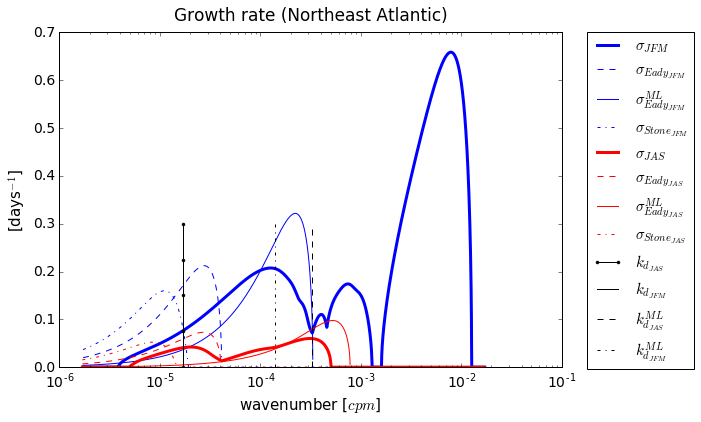

In [62]:
fig = plt.figure(figsize=(9, 6))

ax1 = plt.gca()
ax1.semilogx(
            k_winNEAt*.5*np.pi**-1, sigma2D_winNEAt*24*3600, 
    'b', linewidth=3.0, label=r'$\sigma_{JFM}$')
ax1.semilogx(
            k_winNEAt*.5*np.pi**-1, Eady_winNEAt*24*3600, 
    'b--', label=r'$\sigma_{Eady_{JFM}}$')
ax1.semilogx(
            k_winNEAt*.5*np.pi**-1, Eady_MLwinNEAt*24*3600, 
    'b', label=r'$\sigma^{ML}_{Eady_{JFM}}$')
ax1.semilogx(
            k_winNEAt*.5*np.pi**-1, Stone_winNEAt*24*3600, 
    'b-.', label=r'$\sigma_{Stone_{JFM}}$')
ax1.semilogx(
            k_sumNEAt*.5*np.pi**-1, sigma2D_sumNEAt*24*3600, 
    'r', linewidth=3.0, label=r'$\sigma_{JAS}$')
ax1.semilogx(
            k_sumNEAt*.5*np.pi**-1, Eady_sumNEAt*24*3600, 
    'r--', label=r'$\sigma_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumNEAt*.5*np.pi**-1, Eady_MLsumNEAt*24*3600, 
    'r', label=r'$\sigma^{ML}_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumNEAt*.5*np.pi**-1, Stone_sumNEAt*24*3600, 
    'r-.', label=r'$\sigma_{Stone_{JAS}}$')
ax1.plot(Rd_sumNEAt**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.3,5), 
         'k.-', label=r'$k_{d_{JAS}}$')
ax1.plot(Rd_winNEAt**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.3,5), 
         'k', label=r'$k_{d_{JFM}}$')
ax1.plot(Rd_MLsumNEAt**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.3,5), 
         'k--', label=r'$k^{ML}_{d_{JAS}}$')
ax1.plot(Rd_MLwinNEAt**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.3,5), 
         'k-.', label=r'$k^{ML}_{d_{JFM}}$')
ax1.set_title(r'Growth rate (Northeast Atlantic)', fontsize=17, y=1.02)
ax1.set_ylabel(r'[days$^{-1}$]', fontsize=15)
ax1.set_xlabel(r'wavenumber [$cpm$]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.savefig('POP_growthrate_NEAtlantic_season.png', bbox_inches='tight')

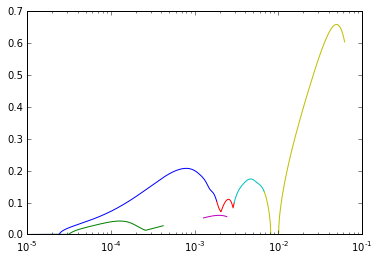

In [141]:
fig = plt.figure()

ax = plt.gca()
ax.semilogx(k_winNEAt[:2790], sigma2D_winNEAt[0, :2790]*24*3600)
ax.semilogx(k_sumNEAt[:2000], sigma2D_sumNEAt[0, :2000]*24*3600)

ax.semilogx(k_winNEAt[2790:3050], sigma2D_winNEAt[0, 2790:3050]*24*3600)
# ax.semilogx(k_sumEP[2000:2300], sigma2D_sumEP[0, 2000:2300]*24*3600)

ax.semilogx(k_winNEAt[3050:3500], sigma2D_winNEAt[0, 3050:3500]*24*3600)
ax.semilogx(k_sumNEAt[2600:2950], sigma2D_sumNEAt[0, 2600:2950]*24*3600)

# ax.semilogx(k_winNEAt[3100:3300], sigma2D_winNEAt[0, 3100:3300]*24*3600)

ax.semilogx(k_winNEAt[3500:4700], sigma2D_winNEAt[0, 3500:4700]*24*3600)

In [163]:
amp_winNEAt1 = amp2D_winNEAt[:, 0, np.nanargmax(sigma2D_winNEAt[0, :2790])]
amp_sumNEAt1 = amp2D_sumNEAt[:, 0, np.nanargmax(sigma2D_sumNEAt[0, :2000])]
amp_winNEAt2 = amp2D_winNEAt[:, 0, np.nanargmax(sigma2D_winNEAt[0, 2790:3050])]
amp_sumNEAt2 = amp2D_sumNEAt[:, 0, np.nanargmax(sigma2D_sumNEAt[0, 2600:2950])]
amp_winNEAt3 = amp2D_winNEAt[:, 0, np.nanargmax(sigma2D_winNEAt[0, 3050:3500])]
amp_winNEAt4 = amp2D_winNEAt[:, 0, np.nanargmax(sigma2D_winNEAt[0, 3500:4700])]

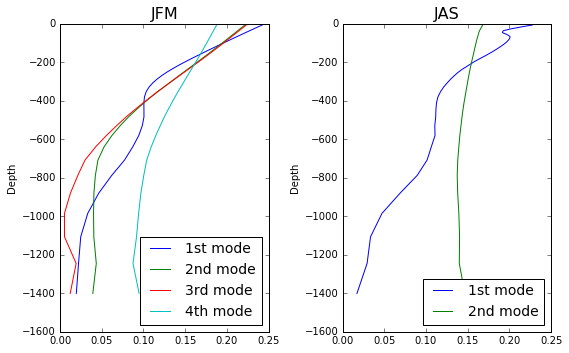

In [220]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(121)
ax1.plot(
            amp_winNEAt1, -zU[:len(amp_winNEAt1)], label='1st mode')
ax1.plot(
            amp_winNEAt2, -zU[:len(amp_winNEAt1)], label='2nd mode')
ax1.plot(
            amp_winNEAt3, -zU[:len(amp_winNEAt1)], label='3rd mode')
ax1.plot(
            amp_winNEAt4, -zU[:len(amp_winNEAt1)], label='4th mode')
ax1.set_title(r'JFM', fontsize=16)
ax1.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(
            amp_sumNEAt1, -zU[:len(amp_sumNEAt1)], label='1st mode')
ax2.plot(
            amp_sumNEAt2, -zU[:len(amp_sumNEAt1)], label='2nd mode')
# ax2.plot(
#             amp_sumNK2, -zU, label='2nd mode')
# ax2.plot(
#             amp_sumNK3, -zU, label='3rd mode')
ax2.set_title(r'JAS', fontsize=16)
ax2.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
# plt.suptitle(r'(lat, lon) = (39.5N, 155.5E)', fontsize=14, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()
plt.savefig('POP_verticalAmp_NEAtlantic_season.png')

## Sargasso Sea (23.5N, 300E)

In [63]:
lats_Sar = (23., 24.)
lons_Sar = (2.99950000e+02, 3.00950000e+02)

In [64]:
(k_winSar, Ug_winSar, Vg_winSar, N2_winSar, Rd_winSar, Rd_MLwinSar, 
     mu_winSar, mu_MLwinSar, zN2_winSar, Ri_invsqrt_winSar, Ri_invsqrt_MLwinSar, 
     Ri_MLwinSar, sigma2D_winSar, amp2D_winSar, 
     Eady_winSar, Eady_MLwinSar, Stone_winSar) = set_of_results(Ug_winmeta,
                                                                                Vg_winmeta, zU, lats_Sar, lons_Sar, N2_winmeta, zN2_winmeta, 
                                                                                               H_winmeta, MLD_winmeta, Ri_winmeta, 5, 5)

Latitude: 23.469  Longitude: 300.45


In [65]:
(k_sumSar, Ug_sumSar, Vg_sumSar, N2_sumSar, Rd_sumSar, Rd_MLsumSar, 
     mu_sumSar, mu_MLsumSar, zN2_sumSar, Ri_invsqrt_sumSar, Ri_invsqrt_MLsumSar, 
     Ri_MLsumSar, sigma2D_sumSar, amp2D_sumSar, 
     Eady_sumSar, Eady_MLsumSar, Stone_sumSar) = set_of_results(Ug_summeta,
                                                                                Vg_summeta, zU, lats_Sar, lons_Sar, N2_summeta, zN2_summeta, 
                                                                                               H_summeta, MLD_summeta, Ri_summeta, 5, 5)

Latitude: 23.469  Longitude: 300.45


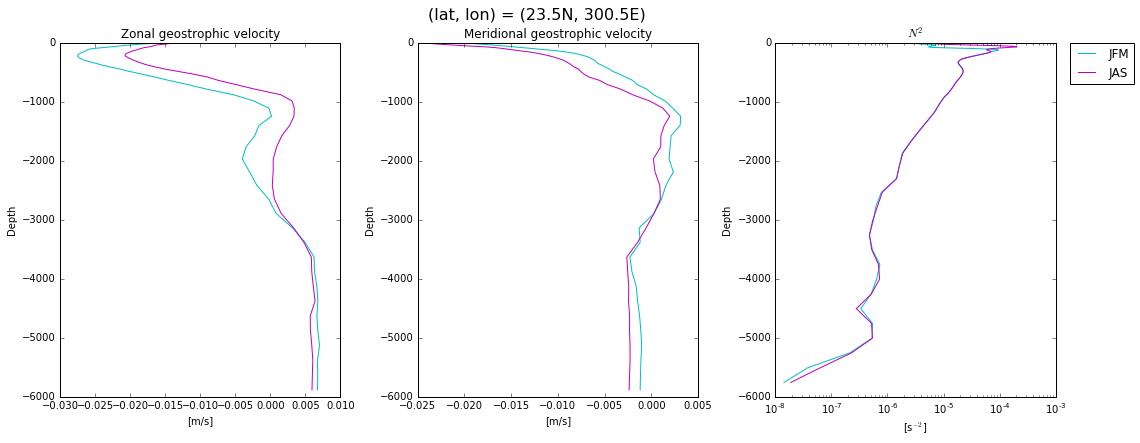

In [203]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.plot(
            Ug_winSar, - zU, 'c', label='winter')
ax1.plot(
            Ug_sumSar, - zU, 'm', label='summer')
ax1.set_title(r'Zonal geostrophic velocity')
ax1.set_ylabel('Depth')
ax1.set_xlabel('[m/s]')

ax2 = fig.add_subplot(132)
ax2.plot(
            Vg_winSar, - zU, 'c', label='winter')
ax2.plot(
            Vg_sumSar, - zU, 'm', label='summer')
ax2.set_title(r'Meridional geostrophic velocity')
ax2.set_ylabel('Depth')
ax2.set_xlabel('[m/s]')

ax3 = fig.add_subplot(133)
ax3.semilogx(
            N2_winSar, zN2_winSar, 'c', label='JFM')
ax3.semilogx(
            N2_sumSar, zN2_sumSar, 'm', label='JAS')
ax3.set_title(r'$N^2$')
ax3.set_ylabel('Depth')
ax3.set_xlabel('[s$^{-2}$]')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.suptitle(r'(lat, lon) = (23.5N, 300.5E)', fontsize=16, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()

In [66]:
np.savez('POP_SargassoSea_growthrates',
         Uwin=Ug_winSar, Usum=Ug_sumSar, Vwin=Vg_winSar, Vsum=Vg_sumSar,
         N2win=N2_winSar, N2sum=N2_sumSar,
         zN2win=zN2_winSar, zN2sum=zN2_sumSar,
         k_win=k_winSar, k_sum=k_sumSar,
         sigma_win=sigma2D_winSar[0], sigma_sum=sigma2D_sumSar[0],
         amp_win=amp2D_winSar[:, 0], amp_sum=amp2D_sumSar[:, 0],
         Eady_win=Eady_winSar, Eady_sum=Eady_sumSar,
         Eady_MLwin=Eady_MLwinSar, Eady_MLsum=Eady_MLsumSar,
         Stone_win=Stone_winSar, Stone_sum=Stone_sumSar,
         Rd_win=Rd_winSar, Rd_sum=Rd_sumSar,
         Rd_MLwin=Rd_MLwinSar, Rd_MLsum=Rd_MLsumSar)

In [67]:
Sarnpz = np.load(os.path.join(basedir, 'POP_SargassoSea_growthrates.npz'))
print Sarnpz.files
k_winSar = Sarnpz['k_win']
k_sumSar = Sarnpz['k_sum']
sigma2D_winSar = Sarnpz['sigma_win']
sigma2D_sumSar = Sarnpz['sigma_sum']
Eady_winSar = Sarnpz['Eady_win']
Eady_sumSar = Sarnpz['Eady_sum']
Eady_MLwinSar = Sarnpz['Eady_MLwin']
Eady_MLsumSar = Sarnpz['Eady_MLsum']
Rd_winSar = Sarnpz['Rd_win']
Rd_sumSar = Sarnpz['Rd_sum']
Rd_MLwinSar = Sarnpz['Rd_MLwin']
Rd_MLsumSar = Sarnpz['Rd_MLsum']

['Vwin', 'Stone_win', 'zN2win', 'N2win', 'Usum', 'sigma_win', 'k_win', 'N2sum', 'Eady_win', 'amp_sum', 'Eady_MLsum', 'Uwin', 'Rd_MLwin', 'Rd_MLsum', 'k_sum', 'zN2sum', 'amp_win', 'Eady_MLwin', 'sigma_sum', 'Rd_win', 'Vsum', 'Eady_sum', 'Rd_sum', 'Stone_sum']


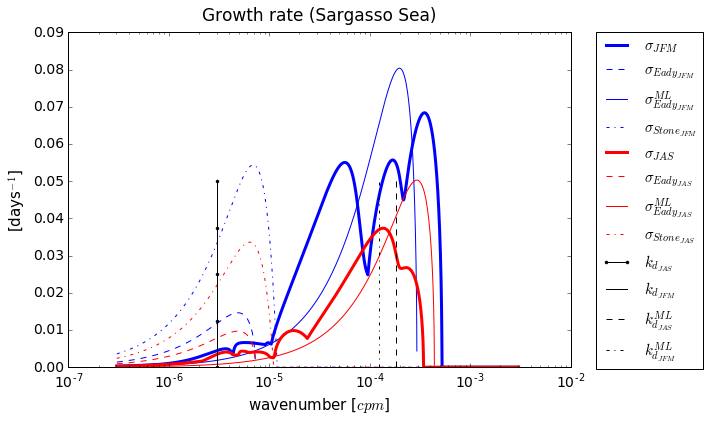

In [69]:
fig = plt.figure(figsize=(9, 6))

ax1 = plt.gca()
ax1.semilogx(
            k_winSar*.5*np.pi**-1, sigma2D_winSar*24*3600, 
    'b', linewidth=3.0, label=r'$\sigma_{JFM}$')
ax1.semilogx(
            k_winSar*.5*np.pi**-1, Eady_winSar*24*3600, 
    'b--', label=r'$\sigma_{Eady_{JFM}}$')
ax1.semilogx(
            k_winSar*.5*np.pi**-1, Eady_MLwinSar*24*3600, 
    'b', label=r'$\sigma^{ML}_{Eady_{JFM}}$')
ax1.semilogx(
            k_winSar*.5*np.pi**-1, Stone_winSar*24*3600, 
    'b-.', label=r'$\sigma_{Stone_{JFM}}$')
ax1.semilogx(
            k_sumSar*.5*np.pi**-1, sigma2D_sumSar*24*3600, 
    'r', linewidth=3.0, label=r'$\sigma_{JAS}$')
ax1.semilogx(
            k_sumSar*.5*np.pi**-1, Eady_sumSar*24*3600, 
    'r--', label=r'$\sigma_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumSar*.5*np.pi**-1, Eady_MLsumSar*24*3600, 
    'r', label=r'$\sigma^{ML}_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumSar*.5*np.pi**-1, Stone_sumSar*24*3600, 
    'r-.', label=r'$\sigma_{Stone_{JAS}}$')
ax1.plot(Rd_sumSar**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.05,5), 
         'k.-', label=r'$k_{d_{JAS}}$')
ax1.plot(Rd_winSar**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.05,5), 
         'k', label=r'$k_{d_{JFM}}$')
ax1.plot(Rd_MLsumSar**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.05,5), 
         'k--', label=r'$k^{ML}_{d_{JAS}}$')
ax1.plot(Rd_MLwinSar**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.05,5), 
         'k-.', label=r'$k^{ML}_{d_{JFM}}$')
ax1.set_title(r'Growth rate (Sargasso Sea)', fontsize=17, y=1.02)
ax1.set_ylabel(r'[days$^{-1}$]', fontsize=15)
ax1.set_xlabel(r'wavenumber [$cpm$]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.savefig('POP_growthrate_Sargasso_season.png', bbox_inches='tight')

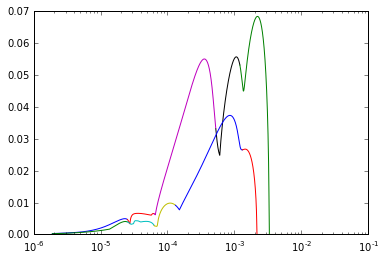

In [162]:
fig = plt.figure()

ax = plt.gca()
ax.semilogx(k_winSar[:1400], sigma2D_winSar[0, :1400]*24*3600)
ax.semilogx(k_sumSar[:1400], sigma2D_sumSar[0, :1400]*24*3600)

ax.semilogx(k_winSar[1400:1900], sigma2D_winSar[0, 1400:1900]*24*3600)
ax.semilogx(k_sumSar[1400:1900], sigma2D_sumSar[0, 1400:1900]*24*3600)

ax.semilogx(k_winSar[1900:3050], sigma2D_winSar[0, 1900:3050]*24*3600)
ax.semilogx(k_sumSar[1900:2300], sigma2D_sumSar[0, 1900:2300]*24*3600)

ax.semilogx(k_winSar[3050:3500], sigma2D_winSar[0, 3050:3500]*24*3600)
ax.semilogx(k_sumSar[2300:3550], sigma2D_sumSar[0, 2300:3550]*24*3600)

ax.semilogx(k_winSar[3500:4700], sigma2D_winSar[0, 3500:4700]*24*3600)
ax.semilogx(k_sumSar[3550:], sigma2D_sumSar[0, 3550:]*24*3600)

In [166]:
amp_winSar1 = amp2D_winSar[:, 0, np.nanargmax(sigma2D_winSar[0, :1400])]
amp_sumSar1 = amp2D_sumSar[:, 0, np.nanargmax(sigma2D_sumSar[0, :1400])]
amp_winSar2 = amp2D_winSar[:, 0, np.nanargmax(sigma2D_winSar[0, 1400:1900])]
amp_sumSar2 = amp2D_sumSar[:, 0, np.nanargmax(sigma2D_sumSar[0, 1400:1900])]
amp_winSar3 = amp2D_winSar[:, 0, np.nanargmax(sigma2D_winSar[0, 1900:3050])]
amp_sumSar3 = amp2D_sumSar[:, 0, np.nanargmax(sigma2D_sumSar[0, 1900:2300])]
amp_winSar4 = amp2D_winSar[:, 0, np.nanargmax(sigma2D_winSar[0, 3050:3500])]
amp_sumSar4 = amp2D_sumSar[:, 0, np.nanargmax(sigma2D_sumSar[0, 2300:3550])]
amp_winSar5 = amp2D_winSar[:, 0, np.nanargmax(sigma2D_winSar[0, 3500:])]
amp_sumSar5 = amp2D_sumSar[:, 0, np.nanargmax(sigma2D_sumSar[0, 3550:])]

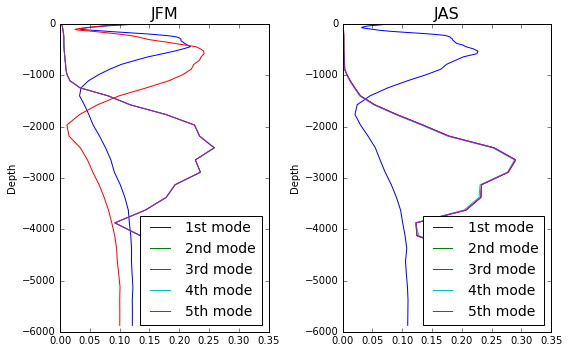

In [222]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(121)
ax1.plot(
            amp_winSar1, -zU[:len(amp_winSar1)], label='1st mode')
ax1.plot(
            amp_winSar2, -zU[:len(amp_winSar1)], label='2nd mode')
ax1.plot(
            amp_winSar3, -zU[:len(amp_winSar1)], label='3rd mode')
ax1.plot(
            amp_winSar4, -zU[:len(amp_winSar1)], label='4th mode')
ax1.plot(
            amp_winSar5, -zU[:len(amp_winSar1)], label='5th mode')
ax1.set_title(r'JFM', fontsize=16)
ax1.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(
            amp_sumSar1, -zU[:len(amp_sumSar1)], label='1st mode')
ax2.plot(
            amp_sumSar2, -zU[:len(amp_sumSar1)], label='2nd mode')
ax2.plot(
            amp_sumSar3, -zU[:len(amp_sumSar1)], label='3rd mode')
ax2.plot(
            amp_sumSar4, -zU[:len(amp_sumSar1)], label='4th mode')
ax2.plot(
            amp_sumSar5, -zU[:len(amp_sumSar1)], label='5th mode')
ax2.set_title(r'JAS', fontsize=16)
ax2.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
# plt.suptitle(r'(lat, lon) = (39.5N, 155.5E)', fontsize=14, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()
plt.savefig('POP_verticalAmp_Sargasso_season.png')

# Southern Ocean

## ACC (51S, 150E)

In [70]:
lats_ACC = (-52., -51.)
lons_ACC = (1.49950000e+02, 1.50950000e+02)

In [71]:
(k_winACC, Ug_winACC, Vg_winACC, N2_winACC, Rd_winACC, Rd_MLwinACC, 
     mu_winACC, mu_MLwinACC, zN2_winACC, Ri_invsqrt_winACC, Ri_invsqrt_MLwinACC, 
     Ri_MLwinACC, sigma2D_winACC, amp2D_winACC, 
     Eady_winACC, Eady_MLwinACC, Stone_winACC) = set_of_results(Ug_winmeta,
                                                                                Vg_winmeta, zU, lats_ACC, lons_ACC, N2_winmeta, zN2_winmeta, 
                                                                                               H_winmeta, MLD_winmeta, Ri_winmeta, 5, 5)

Latitude: -51.683  Longitude: 150.45


In [72]:
(k_sumACC, Ug_sumACC, Vg_sumACC, N2_sumACC, Rd_sumACC, Rd_MLsumACC, 
     mu_sumACC, mu_MLsumACC, zN2_sumACC, Ri_invsqrt_sumACC, Ri_invsqrt_MLsumACC, 
     Ri_MLsumACC, sigma2D_sumACC, amp2D_sumACC, 
     Eady_sumACC, Eady_MLsumACC, Stone_sumACC) = set_of_results(Ug_summeta,
                                                                                Vg_summeta, zU, lats_ACC, lons_ACC, N2_summeta, zN2_summeta, 
                                                                                               H_summeta, MLD_summeta, Ri_summeta, 5, 5)

Latitude: -51.683  Longitude: 150.45


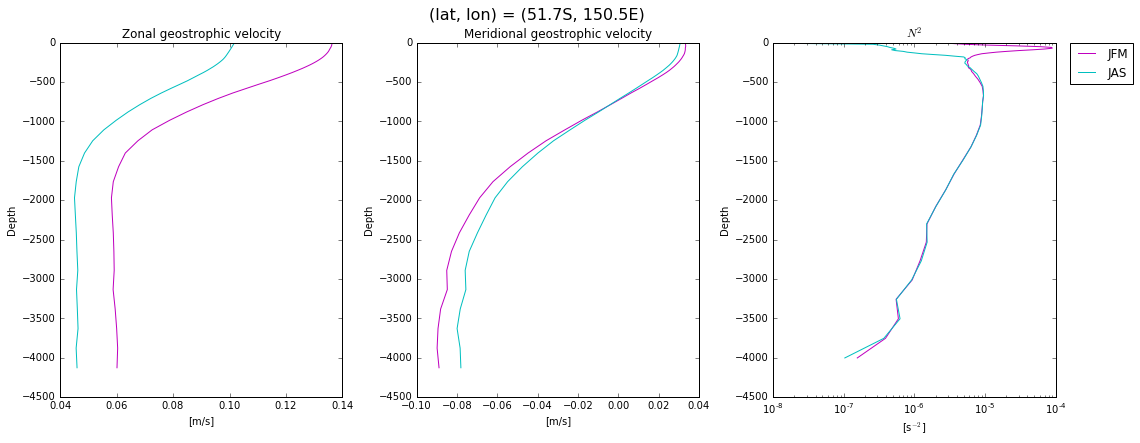

In [206]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.plot(
            Ug_winACC, - zU, 'm', label='JFM')
ax1.plot(
            Ug_sumACC, - zU, 'c', label='JAS')
ax1.set_title(r'Zonal geostrophic velocity')
ax1.set_ylabel('Depth')
ax1.set_xlabel('[m/s]')

ax2 = fig.add_subplot(132)
ax2.plot(
            Vg_winACC, - zU, 'm', label='JFM')
ax2.plot(
            Vg_sumACC, - zU, 'c', label='JAS')
ax2.set_title(r'Meridional geostrophic velocity')
ax2.set_ylabel('Depth')
ax2.set_xlabel('[m/s]')

ax3 = fig.add_subplot(133)
ax3.semilogx(
            N2_winACC, zN2_winACC, 'm', label='JFM')
ax3.semilogx(
            N2_sumACC, zN2_sumACC, 'c', label='JAS')
ax3.set_title(r'$N^2$')
ax3.set_ylabel('Depth')
ax3.set_xlabel('[s$^{-2}$]')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.suptitle(r'(lat, lon) = (51.7S, 150.5E)', fontsize=16, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()

In [73]:
np.savez('POP_ACC_growthrates',
         Uwin=Ug_winACC, Usum=Ug_sumACC, Vwin=Vg_winACC, Vsum=Vg_sumACC,
         N2win=N2_winACC, N2sum=N2_sumACC,
         zN2win=zN2_winACC, zN2sum=zN2_sumACC,
         k_win=k_winACC, k_sum=k_sumACC,
         sigma_win=sigma2D_winACC[0], sigma_sum=sigma2D_sumACC[0],
         amp_win=amp2D_winACC[:, 0], amp_sum=amp2D_sumACC[:, 0],
         Eady_win=Eady_winACC, Eady_sum=Eady_sumACC,
         Eady_MLwin=Eady_MLwinACC, Eady_MLsum=Eady_MLsumACC,
         Stone_win=Stone_winACC, Stone_sum=Stone_sumACC,
         Rd_win=Rd_winACC, Rd_sum=Rd_sumACC,
         Rd_MLwin=Rd_MLwinACC, Rd_MLsum=Rd_MLsumACC)

In [74]:
ACCnpz = np.load(os.path.join(basedir, 'POP_ACC_growthrates.npz'))
print ACCnpz.files
k_winACC = ACCnpz['k_win']
k_sumACC = ACCnpz['k_sum']
sigma2D_winACC = ACCnpz['sigma_win']
sigma2D_sumACC = ACCnpz['sigma_sum']
Eady_winACC = ACCnpz['Eady_win']
Eady_sumACC = ACCnpz['Eady_sum']
Eady_MLwinACC = ACCnpz['Eady_MLwin']
Eady_MLsumACC = ACCnpz['Eady_MLsum']
Rd_winACC = ACCnpz['Rd_win']
Rd_sumACC = ACCnpz['Rd_sum']
Rd_MLwinACC = ACCnpz['Rd_MLwin']
Rd_MLsumACC = ACCnpz['Rd_MLsum']

['Vwin', 'Stone_win', 'zN2win', 'N2win', 'Usum', 'sigma_win', 'k_win', 'N2sum', 'Eady_win', 'amp_sum', 'Eady_MLsum', 'Uwin', 'Rd_MLwin', 'Rd_MLsum', 'k_sum', 'zN2sum', 'amp_win', 'Eady_MLwin', 'sigma_sum', 'Rd_win', 'Vsum', 'Eady_sum', 'Rd_sum', 'Stone_sum']


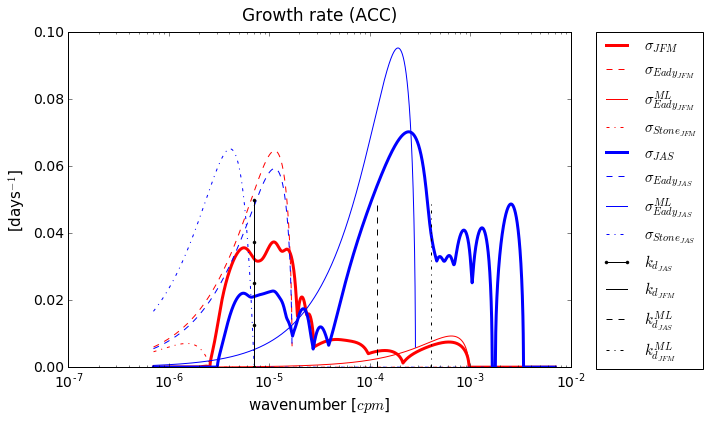

In [76]:
fig = plt.figure(figsize=(9, 6))

ax1 = plt.gca()
ax1.semilogx(
            k_winACC*.5*np.pi**-1, sigma2D_winACC*24*3600, 
    'r', linewidth=3.0, label=r'$\sigma_{JFM}$')
ax1.semilogx(
            k_winACC*.5*np.pi**-1, Eady_winACC*24*3600, 
    'r--', label=r'$\sigma_{Eady_{JFM}}$')
ax1.semilogx(
            k_winACC*.5*np.pi**-1, Eady_MLwinACC*24*3600, 
    'r', label=r'$\sigma^{ML}_{Eady_{JFM}}$')
ax1.semilogx(
            k_winACC*.5*np.pi**-1, Stone_winACC*24*3600, 
    'r-.', label=r'$\sigma_{Stone_{JFM}}$')
ax1.semilogx(
            k_sumACC*.5*np.pi**-1, sigma2D_sumACC*24*3600, 
    'b', linewidth=3.0, label=r'$\sigma_{JAS}$')
ax1.semilogx(
            k_sumACC*.5*np.pi**-1, Eady_sumACC*24*3600, 
    'b--', label=r'$\sigma_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumACC*.5*np.pi**-1, Eady_MLsumACC*24*3600, 
    'b', label=r'$\sigma^{ML}_{Eady_{JAS}}$')
ax1.semilogx(
            k_sumACC*.5*np.pi**-1, Stone_sumACC*24*3600, 
    'b-.', label=r'$\sigma_{Stone_{JAS}}$')
ax1.plot(Rd_sumACC**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.05,5), 
         'k.-', label=r'$k_{d_{JAS}}$')
ax1.plot(Rd_winACC**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.05,5), 
         'k', label=r'$k_{d_{JFM}}$')
ax1.plot(Rd_MLsumACC**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.05,5), 
         'k--', label=r'$k^{ML}_{d_{JAS}}$')
ax1.plot(Rd_MLwinACC**-1*.5*np.pi**-1*np.ones(5), np.linspace(0.,.05,5), 
         'k-.', label=r'$k^{ML}_{d_{JFM}}$')
ax1.set_title(r'Growth rate (ACC)', fontsize=17, y=1.02)
ax1.set_ylabel(r'[days$^{-1}$]', fontsize=15)
ax1.set_xlabel(r'wavenumber [$cpm$]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.savefig('POP_growthrate_ACC_season.png', bbox_inches='tight')

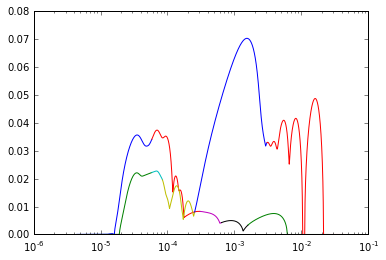

In [187]:
fig = plt.figure()

ax = plt.gca()
ax.semilogx(k_winACC[:1400], sigma2D_winACC[0, :1400]*24*3600)
ax.semilogx(k_sumACC[:1400], sigma2D_sumACC[0, :1400]*24*3600)

ax.semilogx(k_winACC[1400:2300], sigma2D_winACC[0, 1400:2300]*24*3600)
ax.semilogx(k_sumACC[1400:1600], sigma2D_sumACC[0, 1400:1600]*24*3600)

ax.semilogx(k_winACC[2300:2700], sigma2D_winACC[0, 2300:2700]*24*3600)
ax.semilogx(k_sumACC[1600:2200], sigma2D_sumACC[0, 1600:2200]*24*3600)

ax.semilogx(k_winACC[2700:3200], sigma2D_winACC[0, 2700:3200]*24*3600)
ax.semilogx(k_sumACC[2200:3550], sigma2D_sumACC[0, 2200:3550]*24*3600)

ax.semilogx(k_winACC[3200:4700], sigma2D_winACC[0, 3200:4700]*24*3600)
ax.semilogx(k_sumACC[3550:], sigma2D_sumACC[0, 3550:]*24*3600)

In [208]:
amp_winACC1 = amp2D_winACC[:, 0, np.nanargmax(sigma2D_winACC[0, :1400])]
amp_sumACC1 = amp2D_sumACC[:, 0, np.nanargmax(sigma2D_sumACC[0, :1400])]
amp_winACC2 = amp2D_winACC[:, 0, np.nanargmax(sigma2D_winACC[0, 1400:2300])]
amp_sumACC2 = amp2D_sumACC[:, 0, np.nanargmax(sigma2D_sumACC[0, 1400:1600])]
amp_winACC3 = amp2D_winACC[:, 0, np.nanargmax(sigma2D_winACC[0, 2300:2700])]
amp_sumACC3 = amp2D_sumACC[:, 0, np.nanargmax(sigma2D_sumACC[0, 1600:2200])]
amp_winACC4 = amp2D_winACC[:, 0, np.nanargmax(sigma2D_winACC[0, 2700:3200])]
amp_sumACC4 = amp2D_sumACC[:, 0, np.nanargmax(sigma2D_sumACC[0, 2200:3550])]
amp_winACC5 = amp2D_winACC[:, 0, np.nanargmax(sigma2D_winACC[0, 3200:])]
amp_sumACC5 = amp2D_sumACC[:, 0, np.nanargmax(sigma2D_sumACC[0, 3550:])]

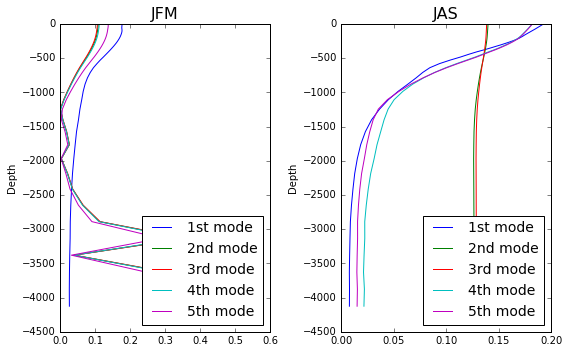

In [224]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(121)
ax1.plot(
            amp_winACC1, -zU[:len(amp_winACC1)], label='1st mode')
ax1.plot(
            amp_winACC2, -zU[:len(amp_winACC1)], label='2nd mode')
ax1.plot(
            amp_winACC3, -zU[:len(amp_winACC1)], label='3rd mode')
ax1.plot(
            amp_winACC4, -zU[:len(amp_winACC1)], label='4th mode')
ax1.plot(
            amp_winACC5, -zU[:len(amp_winACC1)], label='5th mode')
ax1.set_title(r'JFM', fontsize=16)
ax1.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(
            amp_sumACC1, -zU[:len(amp_sumACC1)], label='1st mode')
ax2.plot(
            amp_sumACC2, -zU[:len(amp_sumACC1)], label='2nd mode')
ax2.plot(
            amp_sumACC3, -zU[:len(amp_sumACC1)], label='3rd mode')
ax2.plot(
            amp_sumACC4, -zU[:len(amp_sumACC1)], label='4th mode')
ax2.plot(
            amp_sumACC5, -zU[:len(amp_sumACC1)], label='5th mode')
ax2.set_title(r'JAS', fontsize=16)
ax2.set_ylabel('Depth')
plt.legend(loc='lower right', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
# plt.suptitle(r'(lat, lon) = (39.5N, 155.5E)', fontsize=14, y=1.02)
# cbar = fig.colorbar(cax2)
# cbar.set_label(r'days$^{-1}$', fontsize=14)

plt.tight_layout()
plt.savefig('POP_verticalAmp_ACC_season.png')

# Aggregate data

In [12]:
def aggregate(data, factor=2, mean=True):
    ndim = data.ndim
    shape = data.shape
    # promote single value to list
    if isinstance(factor, int):
        factors = ndim * [factor,]
#         print 'ndim: ', ndim, ' factors: ', factors
    # check we have the right number of dimensions
    assert len(factors) == ndim
    # make sure shapes are compatible
    for s, fac in zip(shape, factors):
#         print 's: ', s, ' fac: ', fac
        assert s % factor == 0
    out = 0
    # it is lazy to use a set...don't have to figure out the necessary logic
    slices = []
    for start_indices in product(*[range(f) for f in factors]):
        slices.append(
            [slice(sidx, s, factor) for sidx, s in zip(start_indices, shape)]
        )
    
    # how would we generalize to other reduce functions?
    result = reduce(np.add, [data[sl] for sl in slices])
    if mean:
        result /= len(slices)
    return result

In [13]:
# maskUg_win = np.isnan(Ug_winT)
# maskVg_win = np.isnan(Vg_winT)
# maskUg_sum = np.isnan(Ug_sumT)
# maskVg_sum = np.isnan(Vg_sumT)
# maskN2_win = np.isnan(N2_win)
# maskN2_sum = np.isnan(N2_sum)
# maskzN2_win = np.isnan(zN2_win)
# maskzN2_sum = np.isnan(zN2_sum)
# maskLat = np.isnan(latT)
# maskLon = np.isnan(lonT)

# Ug_winT[maskUg_win] = 0.
# Vg_winT[maskVg_win] = 0.
# N2_win[maskN2_win] = 0.
# Ug_sumT[maskUg_sum] = 0.
# Vg_sumT[maskVg_sum] = 0.
# N2_sum[maskN2_sum] = 0.

# zN2_win[maskzN2_win] = 0.
# zN2_sum[maskzN2_sum] = 0.
# latT[maskLat] = 0.
# lonT[maskLon] = 0.

In [14]:
# print zN2_win[:, 100, 200]

In [15]:
Nagg = 50

Ug_agg_win = np.empty((Ug_winT.shape[0], 
                   Ug_winT.shape[1]/Nagg, Ug_winT.shape[2]/Nagg))
Ug_agg_win[:] = np.nan
Vg_agg_win = Ug_agg_win.copy()
Ug_agg_sum = Ug_agg_win.copy()
Vg_agg_sum = Ug_agg_win.copy()
N2_agg_win = np.empty((N2_win.shape[0], 
                   N2_win.shape[1]/Nagg, N2_win.shape[2]/Nagg))
N2_agg_win[:] = np.nan
N2_agg_sum = N2_agg_win.copy()
zN2_agg_win = N2_agg_win.copy()
zN2_agg_sum = N2_agg_win.copy()

for k in range(Ug_winT.shape[0]):
        if k == 0:
            dx_agg = aggregate(dxT, factor=Nagg)
            dy_agg = aggregate(dyT, factor=Nagg)
            latT_agg = aggregate(latT, factor=Nagg)
            lonT_agg = aggregate(lonT, factor=Nagg)
        if k < 61:
            Ug_agg_win[k] = aggregate(Ug_winT[k], factor=Nagg)
            Vg_agg_win[k] = aggregate(Vg_winT[k], factor=Nagg)
            Ug_agg_sum[k] = aggregate(Ug_sumT[k], factor=Nagg)
            Vg_agg_sum[k] = aggregate(Vg_sumT[k], factor=Nagg)
            N2_agg_win[k] = aggregate(N2_win[k], factor=Nagg)
            N2_agg_sum[k] = aggregate(N2_sum[k], factor=Nagg)
            zN2_agg_win[k] = aggregate(zN2_win[k], factor=Nagg)
            zN2_agg_sum[k] = aggregate(zN2_sum[k], factor=Nagg)
        else:
            Ug_agg_win[k] = aggregate(Ug_winT[k], factor=Nagg)
            Vg_agg_win[k] = aggregate(Vg_winT[k], factor=Nagg)
            Ug_agg_sum[k] = aggregate(Ug_sumT[k], factor=Nagg)
            Vg_agg_sum[k] = aggregate(Vg_sumT[k], factor=Nagg)

(38, 72)


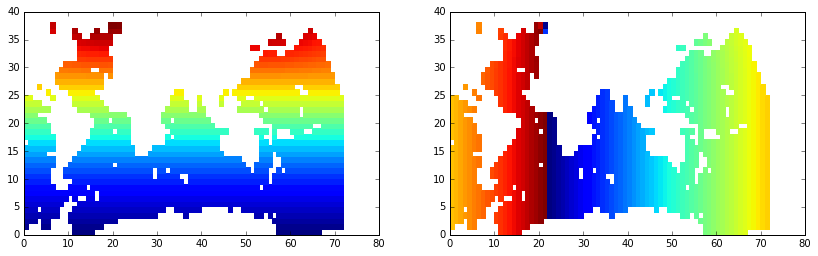

In [16]:
print latT_agg.shape

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(121)
ax1.pcolormesh(np.ma.masked_invalid(latT_agg),
              cmap='jet')

ax2 = fig.add_subplot(122)
ax2.pcolormesh(np.ma.masked_invalid(lonT_agg),
              cmap='jet')

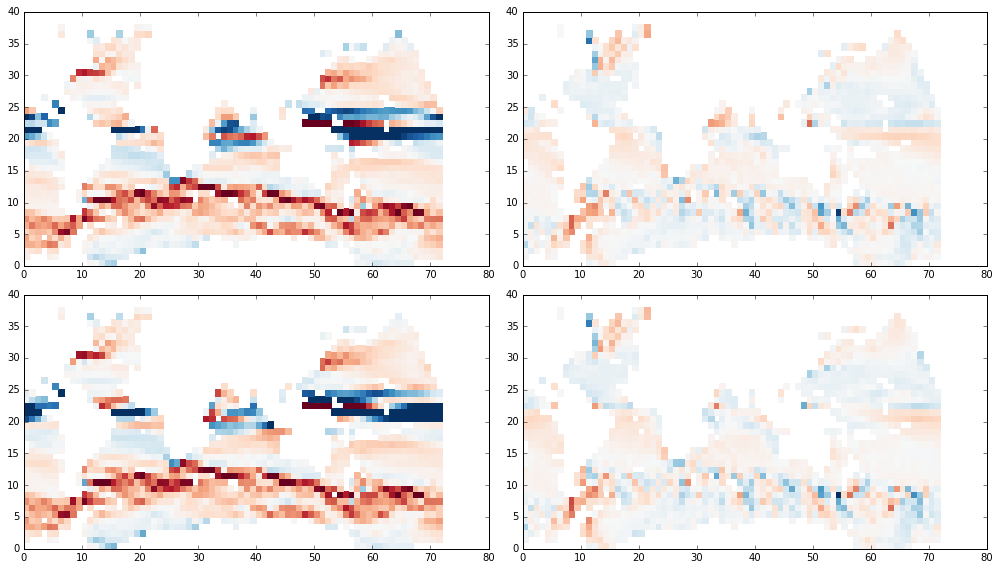

In [12]:
fig = plt.figure(figsize=(14, 8))

ax1 = fig.add_subplot(221)
ax1.pcolormesh(np.ma.masked_invalid(Ug_agg_win[0]),
              cmap='RdBu_r', vmin=-.2, vmax=.2)

ax2 = fig.add_subplot(222)
ax2.pcolormesh(np.ma.masked_invalid(Vg_agg_win[0]),
              cmap='RdBu_r', vmin=-.2, vmax=.2)

ax3 = fig.add_subplot(223)
ax3.pcolormesh(np.ma.masked_invalid(Ug_agg_sum[0]),
              cmap='RdBu_r', vmin=-.2, vmax=.2)

ax4 = fig.add_subplot(224)
ax4.pcolormesh(np.ma.masked_invalid(Vg_agg_sum[0]),
              cmap='RdBu_r', vmin=-.2, vmax=.2)

plt.tight_layout()

In [12]:
masklat = np.isnan(latT_agg)
masklon = np.isnan(lonT_agg)

Ug_masked_sum = np.zeros_like(Ug_agg_sum)
Vg_masked_sum = np.zeros_like(Vg_agg_sum)
N2_masked_sum = np.zeros_like(N2_agg_sum)
zN2_masked_sum = np.zeros_like(zN2_agg_sum)
Ug_masked_win= np.zeros_like(Ug_agg_win)
Vg_masked_win = np.zeros_like(Vg_agg_win)
N2_masked_win = np.zeros_like(N2_agg_win)
zN2_masked_win = np.zeros_like(zN2_agg_win)

for k in range(Ug_agg_sum.shape[0]):
    if k < Ug_agg_sum.shape[0]-1:
        Ug_masked_sum[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(Ug_agg_sum[k], masklat), masklon))
        Vg_masked_sum[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(Vg_agg_sum[k], masklat), masklon))
        N2_masked_sum[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(N2_agg_sum[k], masklat), masklon))
        zN2_masked_sum[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(N2_agg_sum[k], masklat), masklon))

        Ug_masked_win[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(Ug_agg_win[k], masklat), masklon))
        Vg_masked_win[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(Vg_agg_win[k], masklat), masklon))
        N2_masked_win[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(N2_agg_win[k], masklat), masklon))
        zN2_masked_sum[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(zN2_agg_win[k], masklat), masklon))
    else:
        Ug_masked_sum[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(Ug_agg_sum[k], masklat), masklon))
        Vg_masked_sum[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(Vg_agg_sum[k], masklat), masklon))
        
        Ug_masked_win[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(Ug_agg_win[k], masklat), masklon))
        Vg_masked_win[k] = np.ma.masked_invalid(
                np.ma.masked_array(np.ma.masked_array(Vg_agg_win[k], masklat), masklon))

        
latT_masked = np.ma.masked_invalid(latT_agg)
lonT_masked = np.ma.masked_invalid(lonT_agg)

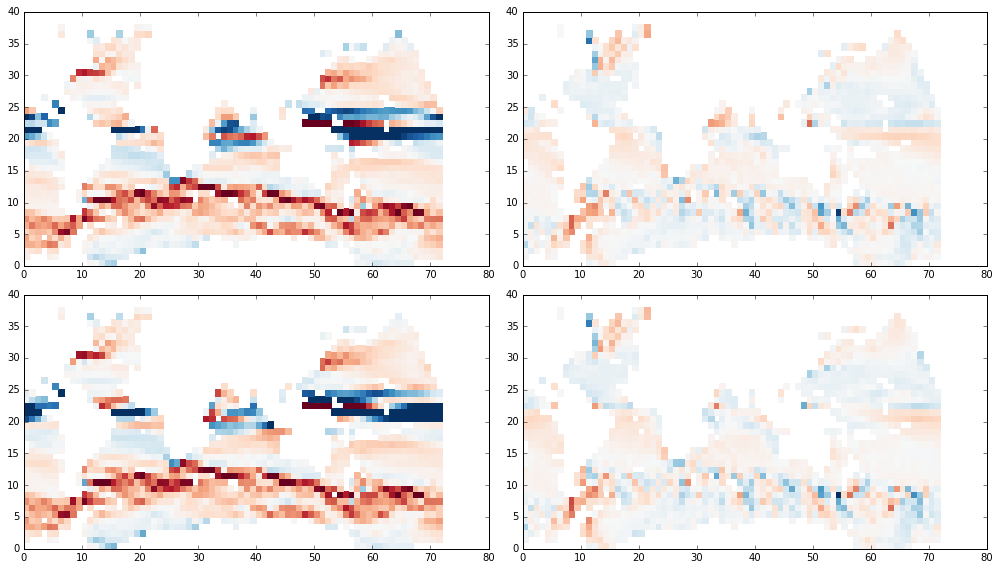

In [25]:
fig = plt.figure(figsize=(14, 8))

ax1 = fig.add_subplot(221)
ax1.pcolormesh(np.ma.masked_invalid(Ug_masked_win[0]),
              cmap='RdBu_r', vmin=-.2, vmax=.2)

ax2 = fig.add_subplot(222)
ax2.pcolormesh(np.ma.masked_invalid(Vg_masked_win[0]),
              cmap='RdBu_r', vmin=-.2, vmax=.2)

ax3 = fig.add_subplot(223)
ax3.pcolormesh(np.ma.masked_invalid(Ug_masked_sum[0]),
              cmap='RdBu_r', vmin=-.2, vmax=.2)

ax4 = fig.add_subplot(224)
ax4.pcolormesh(np.ma.masked_invalid(Vg_masked_sum[0]),
              cmap='RdBu_r', vmin=-.2, vmax=.2)

plt.tight_layout()

In [44]:
print dx_agg.shape[1]

72


# Compute growth rate

In [ ]:
Nstart = 0; N_x = 4
while Nstart <= dx_agg.shape[1]-N_x:
    
    Rd_mat = np.empty((dy_agg.shape[0], 4))
    Rd_mat[:] = np.nan
    growthrate_mat = Rd_mat.copy()
    lengthscale_mat = Rd_mat.copy()
    verticalmode_mat = np.empty((len(zU), dy_agg.shape[0], 4))
    verticalmode_mat[:] = np.nan

    N2_agg = N2_agg_win.copy()
    zN2_agg = zN2_agg_win.copy()
    Ug_agg = Ug_agg_win.copy()
    Vg_agg = Vg_agg_win.copy()

    Ug_masked = Ug_masked_win.copy()
    Vg_masked = Vg_masked_win.copy()
    N2_masked = N2_masked_win.copy()

    save_fname = os.path.join('POP_growthrateSeason_winter%02d%02d' % (Nstart+1, Nstart+N_x))
    print save_fname

    for i in range(Nstart, Nstart+N_x):
        for j in range(dy_agg.shape[0]):

            if np.isnan(N2_agg[:, j, i]).all() or np.isinf(Ug_agg[:, j, i]).any() or np.isnan(Vg_agg[:, j, i]).all() \
                    or np.isnan(Ug_agg[:, j, i]).all() or np.isnan(latT_agg[j, i]) or np.isnan(lonT_agg[j, i]):
                pass

            else:
                print 'Latitude:', round(latT_agg[j, i],2), ' Longitude:', round(lonT_agg[j, i],2), ' grid[j, i]:', j, i
                nz = len(zN2_agg[:, j, i])
                kwargs = {'num_eigen': 2, 'init_vector': None, 'num_Lanczos': nz*10, 'iteration': nz*100, 'tolerance': 0}

                # Due to aggregation, the number of NaN elements differ
                # so we need to zero pad if necessary
                Ug_padded = np.ma.masked_invalid(Ug_masked[:, j, i].copy()).compressed()
                Vg_padded = np.ma.masked_invalid(Vg_masked[:, j, i].copy()).compressed()
                N2_padded = np.ma.masked_invalid(N2_masked[:, j, i].copy()).compressed()
                if len(Ug_padded) < len(Vg_padded):
                    while len(Ug_padded) < len(Vg_padded):
                        Ug_padded = np.append(Ug_padded, 0.)
                elif len(Ug_padded) > len(Vg_padded):
                    while len(Vg_padded) < len(Ug_padded):
                        Vg_padded = np.append(Vg_padded, 0.)
                if len(Ug_padded) < len(N2_padded)+1:
                    while len(Ug_padded) < len(N2_padded)+1:
                        Ug_padded = np.append(Ug_padded, 0.)
                        Vg_padded = np.append(Vg_padded, 0.)
                elif len(Ug_padded) > len(N2_padded)+1:
                    Ug_padded = Ug_padded[:len(N2_padded)+1]
                    Vg_padded = Vg_padded[:len(N2_padded)+1]
                print 'Ug length:', len(Ug_padded), ' Vg length:', len(Vg_padded), 'N2 length:', len(N2_padded)

                zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_agg[:len(N2_padded), j, i], 
                                                                    N2_padded, gsw.earth.f(latT_agg[j, i]), **kwargs)
                if len(Rd) > 1:
    #                 print 'Rossby deformation radius:', Rd[1]
                    Rd_mat[j, i-Nstart] = Rd[1]
                    dx = gsw.earth.distance([lonT_agg[10,48]-.5, lonT_agg[10,48]+.5], 
                                        [round(latT_agg[10,48], 2), round(latT_agg[10,48], 2)])[0][0]
                    print 'dx:', dx
        #                 dy = gsw.earth.distance([lonT[i+1],lonT[i+1]], [latT[j+1]-.5,latT[j+1]+.5])[0][0]
                    Nx = 100
                    Ny = 100
                    k = 2*np.pi*fft.fftshift( fft.fftfreq(Nx, dx/2e1) )
                    l = 2*np.pi*fft.fftshift( fft.fftfreq(Ny, dx/2e1) )
                    k = k[np.absolute(k) < 5.*Rd[1]**-1]
                    l = l[np.absolute(l) < 5.*Rd[1]**-1]
    #                 print 'k length:', len(k), ' l length:', len(l)

                    etax = np.zeros(2)
                    etay = np.zeros(2)

                    zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile( -zN2_agg[:len(N2_padded), j, i], 
                                                                                N2_padded, 
                                                                                gsw.earth.f(latT_agg[j, i]),
                                                                                2.*gsw.earth.OMEGA/gsw.earth.earth_radius * np.cos(np.pi/180.*latT_agg[j, i]),
                                                                                k, l, zU[:len(Ug_padded)], 
                                                                                Ug_padded, 
                                                                                Vg_padded, 
                                                                                etax, etay, Ah=1e1, num=2, **kwargs )
                    kk, ll = np.meshgrid(k, l)
                    growthrate_mat[j, i-Nstart] = np.reshape(w.imag[0], 
                                                      (w.imag[0].shape[0]*w.imag[0].shape[1]))[np.nanargmax(w.imag[0])]
                    lengthscale_mat[j, i-Nstart] = np.sqrt(( (np.reshape(kk, 
                                                        (kk.shape[0]*kk.shape[1]))[np.nanargmax(w.imag[0])])**2 
                                   + (np.reshape(ll, 
                                                 (ll.shape[0]*ll.shape[1]))[np.nanargmax(w.imag[0])])**2 )
                                         )**-1
                    verticalmode_mat[:psi.shape[0], j, i-Nstart] = np.reshape(np.absolute(psi[:, 0]), 
                                                              (psi.shape[0], psi.shape[-1]**2))[:, np.nanargmax(w.imag[0])]

    np.savez(save_fname,
        growthrate=growthrate_mat, verticalmode=verticalmode_mat,
        lengthscale=lengthscale_mat, Rd=Rd_mat, 
        lat=latT_agg, lon=lonT_agg
        )
    
    Nstart += 4

POP_growthrateSeason_winter0104
Latitude: -71.1  Longitude: 252.5  grid[j, i]: 1 0
Ug length: 37  Vg length: 37 N2 length: 36
dx: 73592.2116511
Latitude: -68.99  Longitude: 252.5  grid[j, i]: 2 0
Ug length: 52  Vg length: 52 N2 length: 51
dx: 73592.2116511
Latitude: -66.87  Longitude: 252.5  grid[j, i]: 3 0
Ug length: 53  Vg length: 53 N2 length: 52
dx: 73592.2116511
Latitude: -64.75  Longitude: 252.5  grid[j, i]: 4 0
Ug length: 57  Vg length: 57 N2 length: 56
dx: 73592.2116511
Latitude: -62.53  Longitude: 252.5  grid[j, i]: 5 0
Ug length: 58  Vg length: 58 N2 length: 57
dx: 73592.2116511
Latitude: -60.13  Longitude: 252.5  grid[j, i]: 6 0
Ug length: 55  Vg length: 55 N2 length: 54
dx: 73592.2116511
Latitude: -57.54  Longitude: 252.5  grid[j, i]: 7 0
Ug length: 54  Vg length: 54 N2 length: 53
dx: 73592.2116511
Latitude: -54.76  Longitude: 252.5  grid[j, i]: 8 0
Ug length: 52  Vg length: 52 N2 length: 51
dx: 73592.2116511
Latitude: -51.77  Longitude: 252.5  grid[j, i]: 9 0
Ug length: 52

In [ ]:
print lonT_agg.shape
print lonT_agg[10,48], latT_agg[10,48]
print gsw.earth.distance([lonT_agg[10,48]-.5, lonT_agg[10,48]+.5], [-48.5644357161, -48.5644357161])[0][0]
print gsw.earth.distance([lonT_agg[10,48]-.5, lonT_agg[10,48]+.5], 
                                        [round(latT_agg[10,48], 2), round(latT_agg[10,48], 2)])[0][0]
print round(latT_agg[10,48], 2)

In [16]:
winter = np.load(os.path.join(basedir, 'POP_growthrateSeason_winter.npz'))
growth_win = winter['growthrate']
lat = winter['lat']
lon = winter['lon']

summer = np.load(os.path.join(basedir, 'POP_growthrateSeason_summer.npz'))
growth_sum = winter['growthrate']

In [17]:
print lat.shape, lon.shape, growth_win.shape, growth_sum.shape, dy_agg.shape, dx_agg.shape

(38, 72) (38, 72) (38, 72) (38, 72) (38, 72) (38, 72)


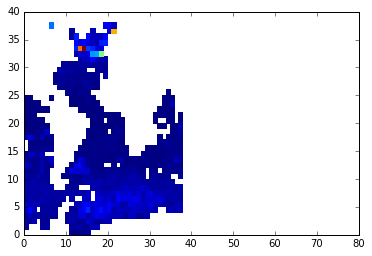

In [22]:
plt.pcolormesh(np.ma.masked_invalid(growth_sum*24*3600))